# Algorithm for Trading

## Technical tools project :
-  ### Trend detection
-  ### Psychologic threshold 

## Algorithmic trading  :
-  ### Divergence detection strategy 
-  ### Signal verification using machine learning 

# Disclaimer:

Plotly interactive graphs are not supported by github due to the interface and project size limit, so each ‘plot_trend’ function call is commented followed by a screenshot of the rendering.

I invite you to download the notbook locally and try it out for yourself by uncommenting the Plotly graphs. You can test any period and even other assets if you have the necessary data.

Thank you for your understanding

## I. Data preparation

In [51]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image, display


#### Definition of dynamic crypto periods according to dates

In [2]:
BNB_USDT=pd.read_csv('BNBUSDT_1h_20171106_20250328.csv')
BNB_USDT['open_time']=pd.to_datetime(BNB_USDT['open_time'])
BNB_USDT['close_time']=pd.to_datetime(BNB_USDT['close_time'])
BNB_USDT_zoom=BNB_USDT[(BNB_USDT['open_time'].dt.year==2024)]

BNB_USDT_zoom_week = BNB_USDT[
    (BNB_USDT['open_time'] >= '2021-10-03') & 
    (BNB_USDT['open_time'] < '2022-04-30')
]

BNB_USDT_zoom_week['timestamp'] = BNB_USDT_zoom_week['open_time'].view('int64') // 10**11
BNB_USDT_zoom_week=BNB_USDT_zoom_week.reset_index()

BNB_USDT_zoom_week.head()

index           open_time   open   high    low  close     volume  \
0  34124 2021-10-03 00:00:00  427.0  434.0  421.5  424.1  76338.675   
1  34125 2021-10-03 01:00:00  424.1  428.0  423.0  425.4  45529.814   
2  34126 2021-10-03 02:00:00  425.4  429.9  424.2  426.3  34666.935   
3  34127 2021-10-03 03:00:00  426.3  429.8  424.8  429.7  23436.178   
4  34128 2021-10-03 04:00:00  429.7  430.9  428.2  429.0  21449.370   

           close_time  quote_asset_volume  trades  \
0 2021-10-03 00:59:59        3.265592e+07   41858   
1 2021-10-03 01:59:59        1.936317e+07   27599   
2 2021-10-03 02:59:59        1.480647e+07   24712   
3 2021-10-03 03:59:59        1.000444e+07   14501   
4 2021-10-03 04:59:59        9.210723e+06   13949   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume   symbol  \
0                    35058.975                  1.500440e+07  BNBUSDT   
1                    21905.369                  9.317400e+06  BNBUSDT   
2                    17520.079                  7.482938e+06  BNBUSDT   
3                    12442.150                  5.312752e+06  BNBUSDT   
4                    10892.043                  4.677010e+06  BNBUSDT   

   timestamp  
0   16332192  
1   16332228  
2   16332264  
3   16332300  
4   16332336

#### Data visualization with matplotlib 

Text(0.5, 1.0, 'BNB_USDT')

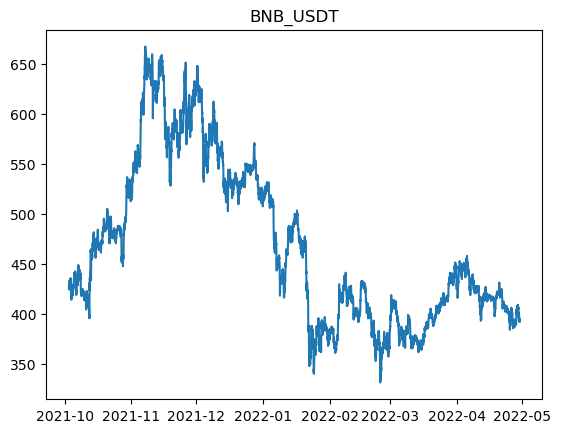

In [3]:
plt.plot (BNB_USDT_zoom_week['open_time'], BNB_USDT_zoom_week['open'])
plt.title('BNB_USDT')

#### Data visualization with plotly 

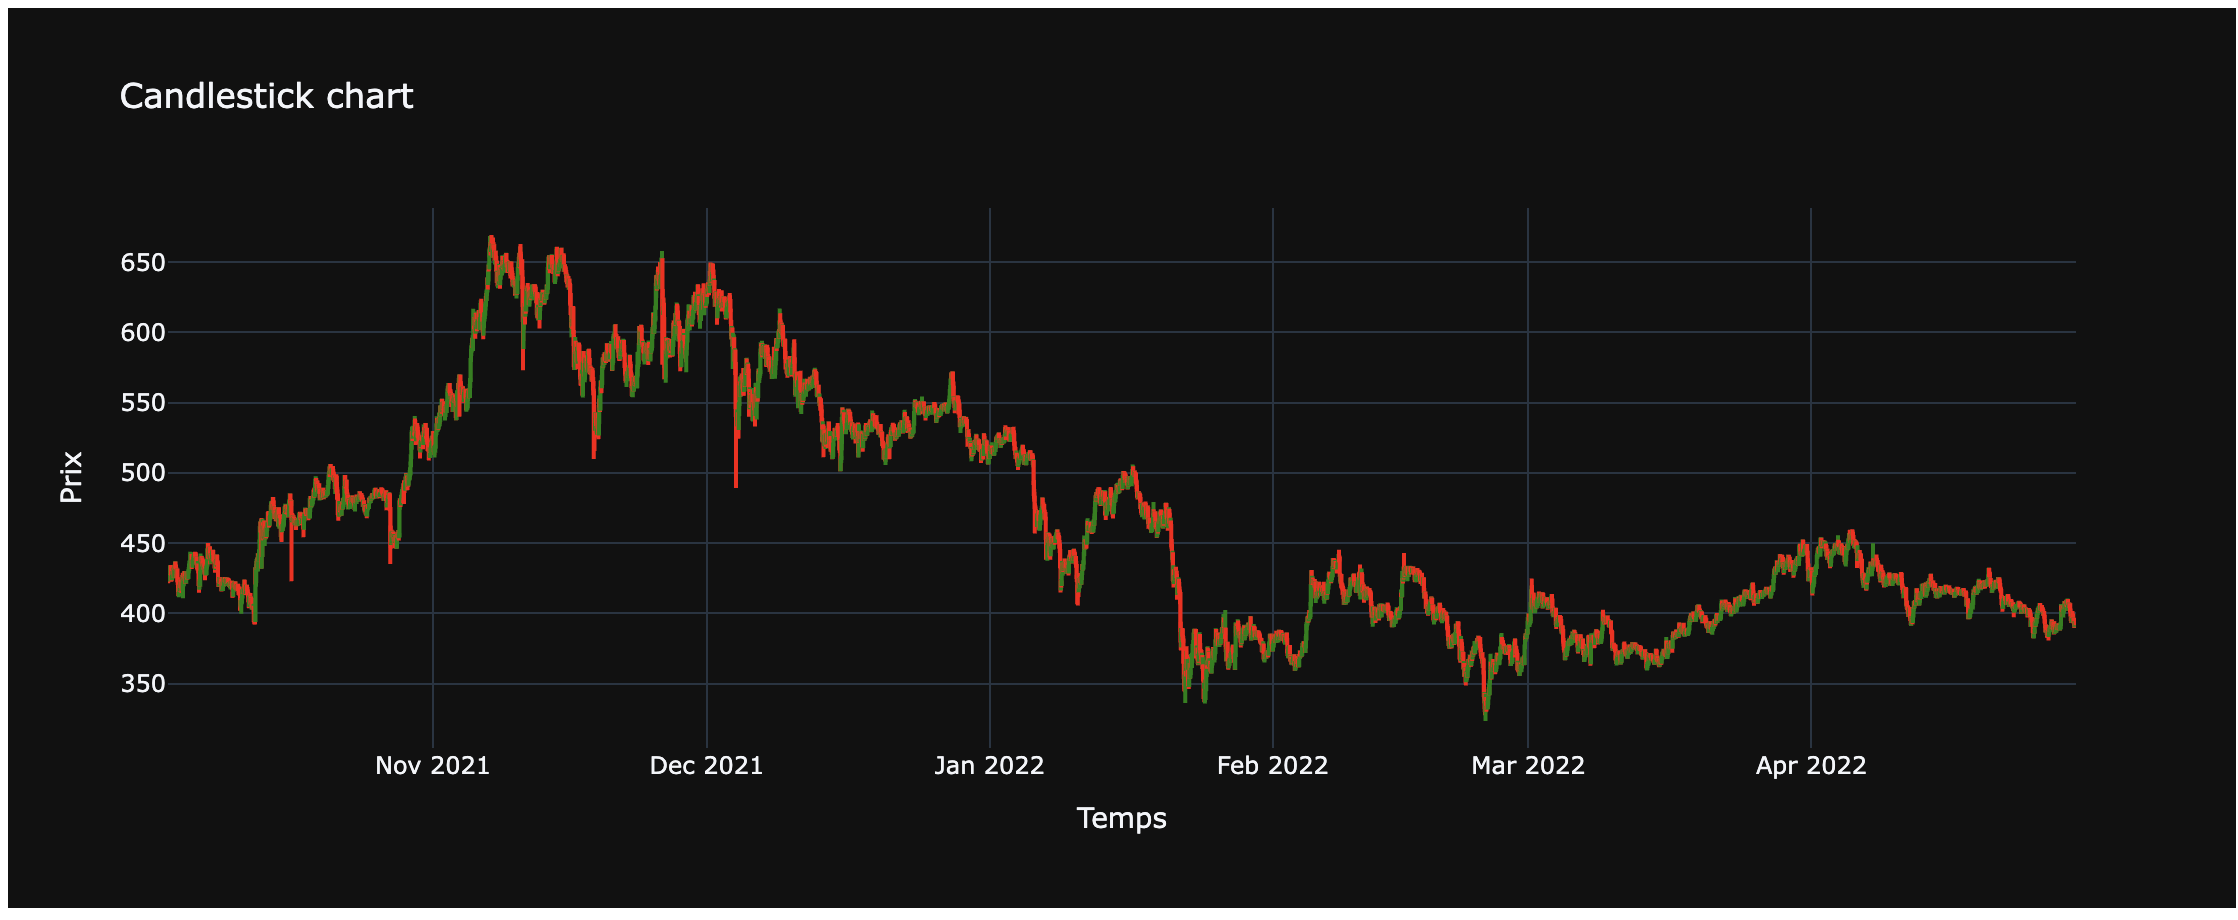

In [52]:
def plot_candlesticks(df, title="Candlestick chart"):
   
    fig = go.Figure(data=[go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )
    fig.show()

#plot_candlesticks(BNB_USDT_zoom_week)
display(Image(filename='chart1.png'))

## II. Detracting from the latest trend : 

### Methodology : 
-  Calculation of moving averages for each selected time period
-  Detection of the last reversal in the direction of variation of the moving average
-  Delimitation of the working area 
-  Definition of trend resistance in the working area
-  Definition of support for the trend in the working area
-  Implementation of support and resistance in the data set for data visualization 

### Definition of study period size : 
-  Moving average over a given period 
-  Moving maximum peak within a given period 
-  Minimum moving peak for a given period 

In [5]:
moyenne_mobile=[]
BNB_USDT_zoom_week['periode']=BNB_USDT_zoom_week['open_time'].dt.floor('200H') 
moyenne_mobile=BNB_USDT_zoom_week.groupby('periode')['open'].mean()
min_mobile=BNB_USDT_zoom_week.groupby('periode')['low'].min()
max_mobile=BNB_USDT_zoom_week.groupby('periode')['high'].max()

### Definition of the last price trend by : 

-  find_trend_index :    Detects the last sequence of consecutive variations (same sign) in the series and returns its starting point and length.

-  find_trend :   Extracts the sub-series corresponding to the last trend detected in the moving average, with its associated max/min.
-  calc_line_params :    Calculate the coefficients a and b of the line passing through two points (y = ax + b).
-  distance_to_line :     Calculate the vertical distance between a point (x, y) and the line y = ax + b.
-  fit_resistance_from_maxima :  Attempts to fit a resistance line to a series of maxima, with a tolerance on overshoots.
-  fit_support_from_minimum :  Tries to fit a support line to a series of minima, tolerating slight negative deviations.
-  define_resistance :  Builds a resistance line between two local peaks detected in the price data.

-  define_support :  Builds a support line between two local troughs detected in the price data.

In [6]:
def find_trend_index (moyenne_mobile) : 

    for i in range(1, len(moyenne_mobile)+1):
        sign = np.sign(moyenne_mobile[-i])        # On récupère le signe de la variation de al moyenne mobile du plus récent au plus antérieur
        count=0
        for j in range(len(moyenne_mobile)-i) :
            tmp=0
            if np.sign(moyenne_mobile[-1-i-j])==sign : # On remonte dans la série pour compter combien de variations ont ce même signe
                count+=1
            elif (tmp==0) and (abs(-2-i-j)<=len(moyenne_mobile)) :  # si le signe est différent on test la moyenne mobile suivante comme une "tolérance"
                if np.sign(moyenne_mobile[-2-i-j])==sign :          # si pas de tolérance, on stoppe 
                    count+=1
                else :
                    break
            else :                      
                break
        if count>=2 :
            break 
    return len(moyenne_mobile)-(i), count+1

def find_trend(moyenne_mobile, max_mobile, min_mobile) : 
    index, frame=find_trend_index (moyenne_mobile.diff())
    if frame<2 : 
        raise ValueError("Il faut au moins 3 période pour une tendance.")
    
    # On extrait la portion de tendance sur les 3 séries : moyenne, maximums et minimums
    moyenne_mobile=moyenne_mobile[index-frame:index+1]
    max_mobile=max_mobile[index-frame:index+1]
    min_mobile=min_mobile[index-frame:index+1]  

    #model_supp = TheilSenRegressor()
    #model_supp.fit(np.arange(len(min_mobile)).reshape(-1, 1), min_mobile.values)
    #x_support = model_supp.coef_  
    #y_support = model_supp.intercept_

    #model_res = TheilSenRegressor()
    #model_res.fit(np.arange(len(max_mobile)).reshape(-1, 1), max_mobile.values)
    #x_res = model_res.coef_  
    #y_res = model_res.intercept_
    
    return  moyenne_mobile, max_mobile, min_mobile, frame, index


In [7]:
def calc_line_params(x1, y1, x2, y2):
    a = (y2 - y1) / (x2 - x1) if x2 != x1 else 0
    b = y1 - a * x1
    return a, b

def distance_to_line(a, b, x, y):
    return y - (a * x + b)

def fit_resistance_from_maxima(max_series, close_series=None, tolerance=0.01):
    if len(max_series) < 2:
        raise ValueError("Il faut au moins deux points pour tracer une droite.")

    max_series = max_series.dropna()
    dates = max_series.index
    y = max_series.values
    x = np.arange(len(y))

    def check_fit_resistance(x1_idx, x2_idx):
        a, b = calc_line_params(x[x1_idx], y[x1_idx], x[x2_idx], y[x2_idx])
        n_points = 2
        n_touches = 0
        max_dist = 0

        for i in range(len(x)):
            if i in (x1_idx, x2_idx):
                continue
            y_line = a * x[i] + b
            delta = y[i] - y_line

            if delta > y_line * tolerance:   # point trop au-dessus
                return None  
            elif abs(delta) <= y_line * tolerance:
                n_touches += 1
            else:
                max_dist = np.maximum(max_dist, abs(delta))

        return {
            'a': a,
            'b': b,
            'touches': n_touches + n_points,
            'max_dist': max_dist,
            'x1_idx': x1_idx,
            'x2_idx': x2_idx
        }
    for start_idx in range(len(x) - 2):  # on s'arrête pour garder au moins 3 points
        result = check_fit_resistance(start_idx, len(x) - 1)
        if result:
            sub_series = max_series.iloc[result['x1_idx']:result['x2_idx'] + 1]
            return result['a'], result['b'], sub_series
    
    raise ValueError("Impossible de trouver une résistance valide selon les critères donnés.")

def fit_support_from_minimum(min_series, close_series=None, tolerance=0.01):
    if len(min_series) < 2:
        raise ValueError("Il faut au moins deux points pour tracer une droite.")

    min_series = min_series.dropna()
    dates = min_series.index
    y = min_series.values
    x = np.arange(len(y))

    def check_fit_support(x1_idx, x2_idx):
        a, b = calc_line_params(x[x1_idx], y[x1_idx], x[x2_idx], y[x2_idx])
        n_points = 2
        n_touches = 0
        max_dist = 0

        for i in range(len(x)):
            if i in (x1_idx, x2_idx):
                continue
            y_line = a * x[i] + b
            delta = y[i] - y_line

            if delta < -abs(y_line * tolerance): # point trop en-dessous
                return None  

            elif abs(delta) <= abs(y_line * tolerance):
                n_touches += 1

            else:
                max_dist = np.maximum(max_dist, abs(delta))
        return {
            'a': a,
            'b': b,
            'touches': n_touches + n_points,
            'max_dist': max_dist,
            'x1_idx': x1_idx,
            'x2_idx': x2_idx
        }
    for start_idx in range(len(x) - 2):  # on s'arrête pour garder au moins 3 points
        result = check_fit_support(start_idx, len(x) - 1)
        if result:
            sub_series = min_series.iloc[result['x1_idx']:result['x2_idx'] + 1]
            return result['a'], result['b'], sub_series
    
    raise ValueError("Impossible de trouver une résistance valide selon les critères donnés.")

In [8]:
def define_resistance (new_max_mobile, df) : 

    # trouver l'indice du premier et dernier pique de la trend détecté
    target_start=new_max_mobile.index[0]
    start_index_resistance=df[(df['periode']==target_start) & (df['high']==new_max_mobile[0])].index[0]
    target_end=new_max_mobile.index[-1]
    end_index_resistance=df[(df['periode']==target_end) & (df['high']==new_max_mobile[-1])].index[0]
    
    #définir lles coordonnées du premier et dernier pique de la trend 
    x0 = start_index_resistance
    x1 = end_index_resistance
    y0 = new_max_mobile[0]
    y1 = new_max_mobile[-1]

    #définir la pente et l'intercepte de la résistance 
    a, b = calc_line_params(x0, y0, x1, y1)

    # on crée une series qui de meme taille que le data frame
    resistance = np.zeros(df.shape[0])

    # on place entre les indices du premier et dernier pique la résistance
    x_range = np.arange(x0, x1 + 1)
    resistance[x0:x1 + 1] = a * x_range + b

    return resistance

def define_support (new_min_mobile, df) : 

    # trouver l'indice du premier et dernier pique de la trend détecté
    target_start=new_min_mobile.index[0]
    start_index_support=df[(df['periode']==target_start) & (df['low']==new_min_mobile[0])].index[0]
    target_end=new_min_mobile.index[-1]
    end_index_support=df[(df['periode']==target_end) & (df['low']==new_min_mobile[-1])].index[0]
    
    #définir les coordonnées du premier et dernier pique de la trend 
    x0 = start_index_support
    x1 = end_index_support
    y0 = new_min_mobile[0]
    y1 = new_min_mobile[-1]

    #définir la pente et l'intercepte du support 
    a, b = calc_line_params(x0, y0, x1, y1)

    # on crée une series qui est de meme taille que le data frame
    support = np.zeros(df.shape[0])

    # on place entre les indices du premier et dernier pique le support
    x_range = np.arange(x0, x1 + 1)
    support[x0:x1 + 1] = a * x_range + b

    return support

##### Delimiting the work area 


In [9]:
# we retrieve all the useful information between the terminals of the identified period. 
moyenne, max, min, frame, index=find_trend(moyenne_mobile, max_mobile, min_mobile) 

##### Defining the resistance of the trend in the working area


In [10]:
# we recover the slope and the intercept of the resistance
a_resistance, b_resistance , new_max_mobile=fit_resistance_from_maxima(max)

##### Defining trend support in the work area

In [11]:
# we recover the slope and the intercept of the support
a_support, b_support , new_min_mobile=fit_support_from_minimum(min)

##### Implementation of support and resistance in the data set for Data Visualization 

In [12]:
BNB_USDT_zoom_week['resistance']=define_resistance(new_max_mobile, BNB_USDT_zoom_week)
BNB_USDT_zoom_week['resistance']=BNB_USDT_zoom_week['resistance'].replace(0.0, np.nan)

BNB_USDT_zoom_week['support']=define_support(new_min_mobile, BNB_USDT_zoom_week)
BNB_USDT_zoom_week['support']=BNB_USDT_zoom_week['support'].replace(0.0, np.nan)

### Results display : plot_trend

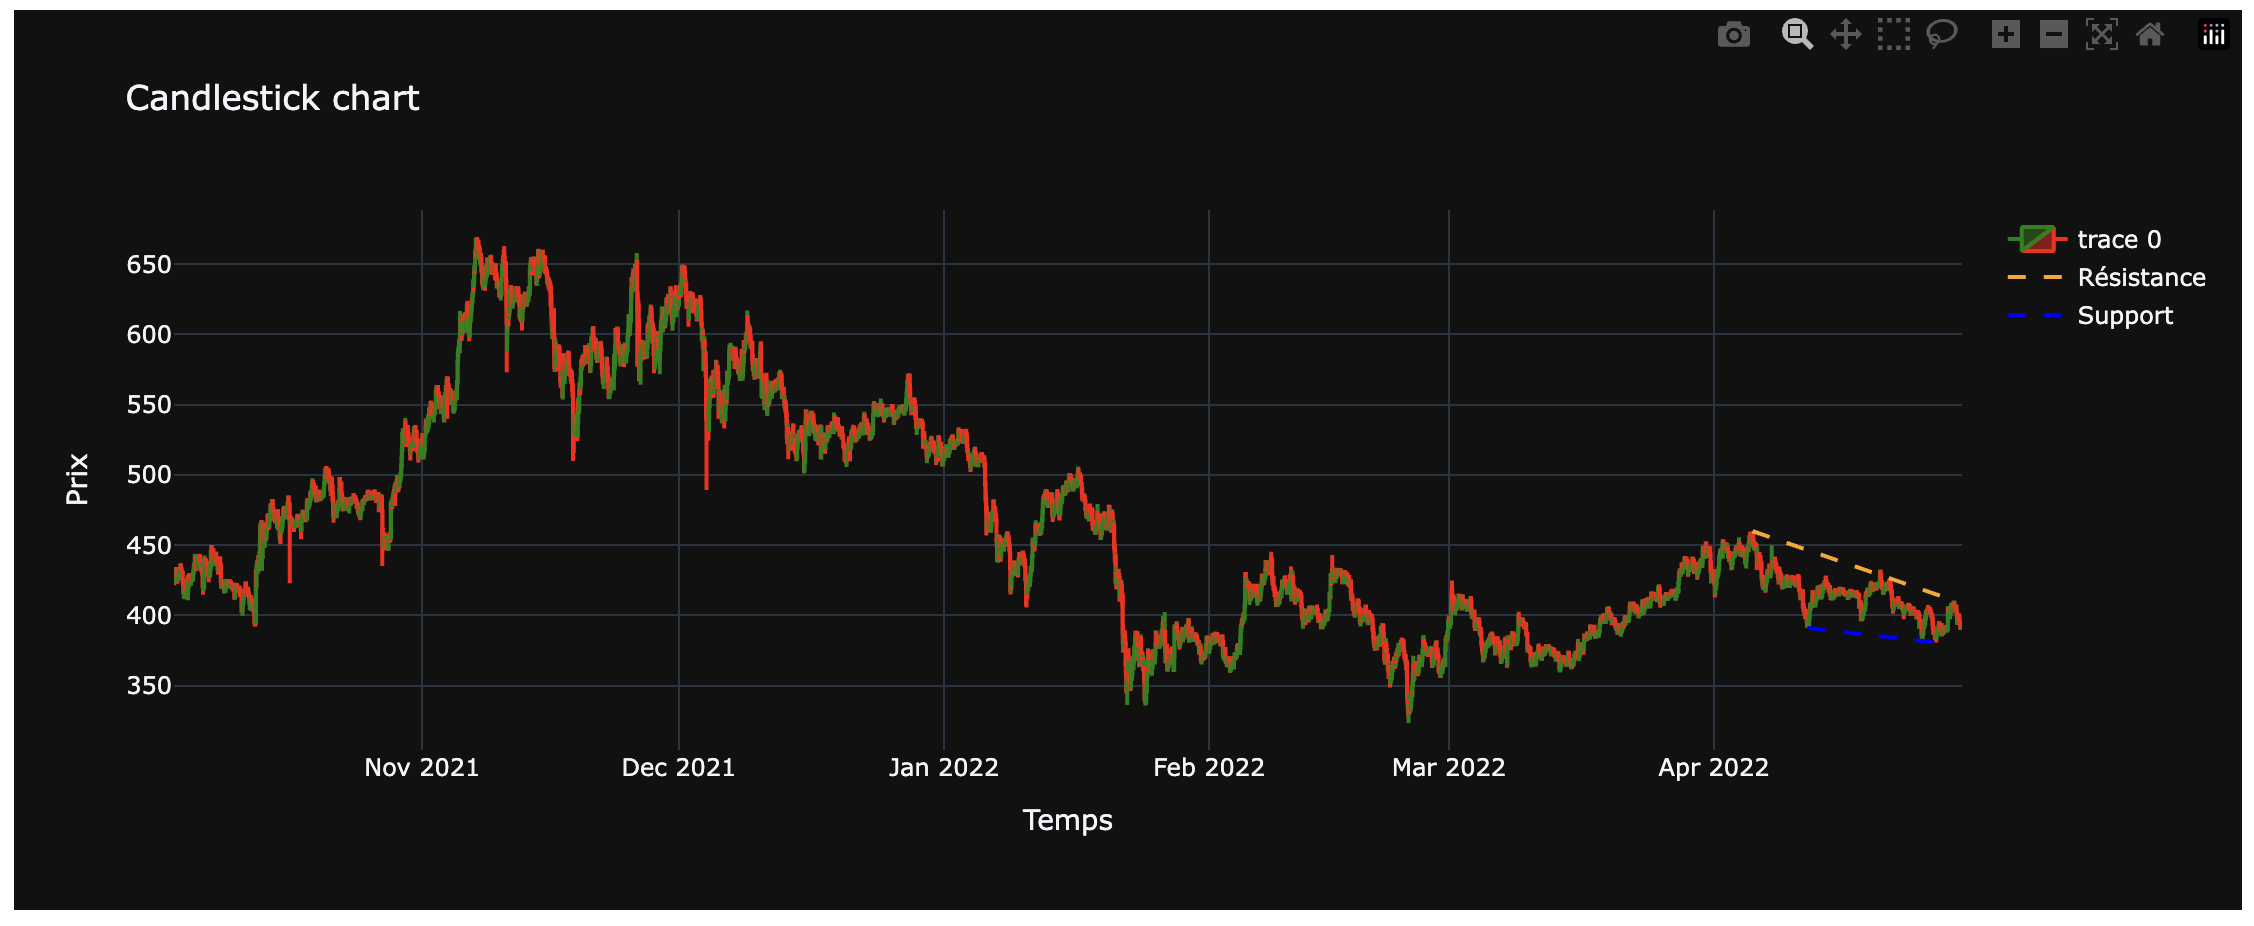

In [55]:
def plot_trend (df, threshold=None, max_peak=None, min_peak=None,title="Candlestick chart"):

   # Affichage des candlestck
    fig = go.Figure(data=[go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )

    # Affichage de la dernière tendance 
    fig.add_trace(go.Scatter(
    x=df['open_time'],
    y=df['resistance'],
    mode='lines',
    line=dict(color='orange', dash='dash'),
    name='Résistance'
    ))

    fig.add_trace(go.Scatter(
    x=df['open_time'],
    y=df['support'],
    mode='lines',
    line=dict(color='blue', dash='dash'),
    name='Support'
    ))

    # Affichage peak maximum si detecté
    if max_peak is not None and len(max_peak) > 0:
        fig.add_trace(go.Scatter(
        x=df.loc[max_peak, 'open_time'],
        y=df.loc[max_peak, 'high'],
        mode='markers',
        marker=dict(color='red', size=10),
        name='Peaks'
    ))
        
    # Affichage des candlestck
    if threshold!=None :
        for seuil in threshold :
            fig.add_hline(y=seuil[0], line=dict(color='green', dash='dash'), annotation_text=f'Seuil {seuil[0]}', annotation_position='right')
    fig.show()

#plot_trend(BNB_USDT_zoom_week)
display(Image(filename='chart2.png'))

## III. Psychological level detection

### Exploration 1: 
-  We draw a constant and measure each time how many points cut it, we proceed in this way on all the possible prices of the chosen frame, and then we compare the results with each other and keep the straight line or the n straight lines with the most points. 

In [14]:
def find_pyscho (df, cutting=100) :
    max_price=df['high'].max()
    min_price=df['low'].min()
    result={}
    # Pour chaque niveau de prix dans l'intervalle [min_price, max_price], on compte le nombre de bougies traversant ce niveau.
    for val in np.linspace(min_price, max_price, cutting) : 
        count=df[(df['low']<=val) & (df['high']>=val)].shape[0]
        result[val] = count
    
    return result

In [15]:
#récupération du dictionnaire contenant les n-best threshold

psycho_threshold=find_pyscho(BNB_USDT_zoom_week,20)
best_psycho_threshold=sorted(psycho_threshold.items(), key=lambda x: -x[1])[:4]
best_psycho_threshold

[(414.5, 179), (432.7, 132), (396.3, 128), (378.1, 125)]

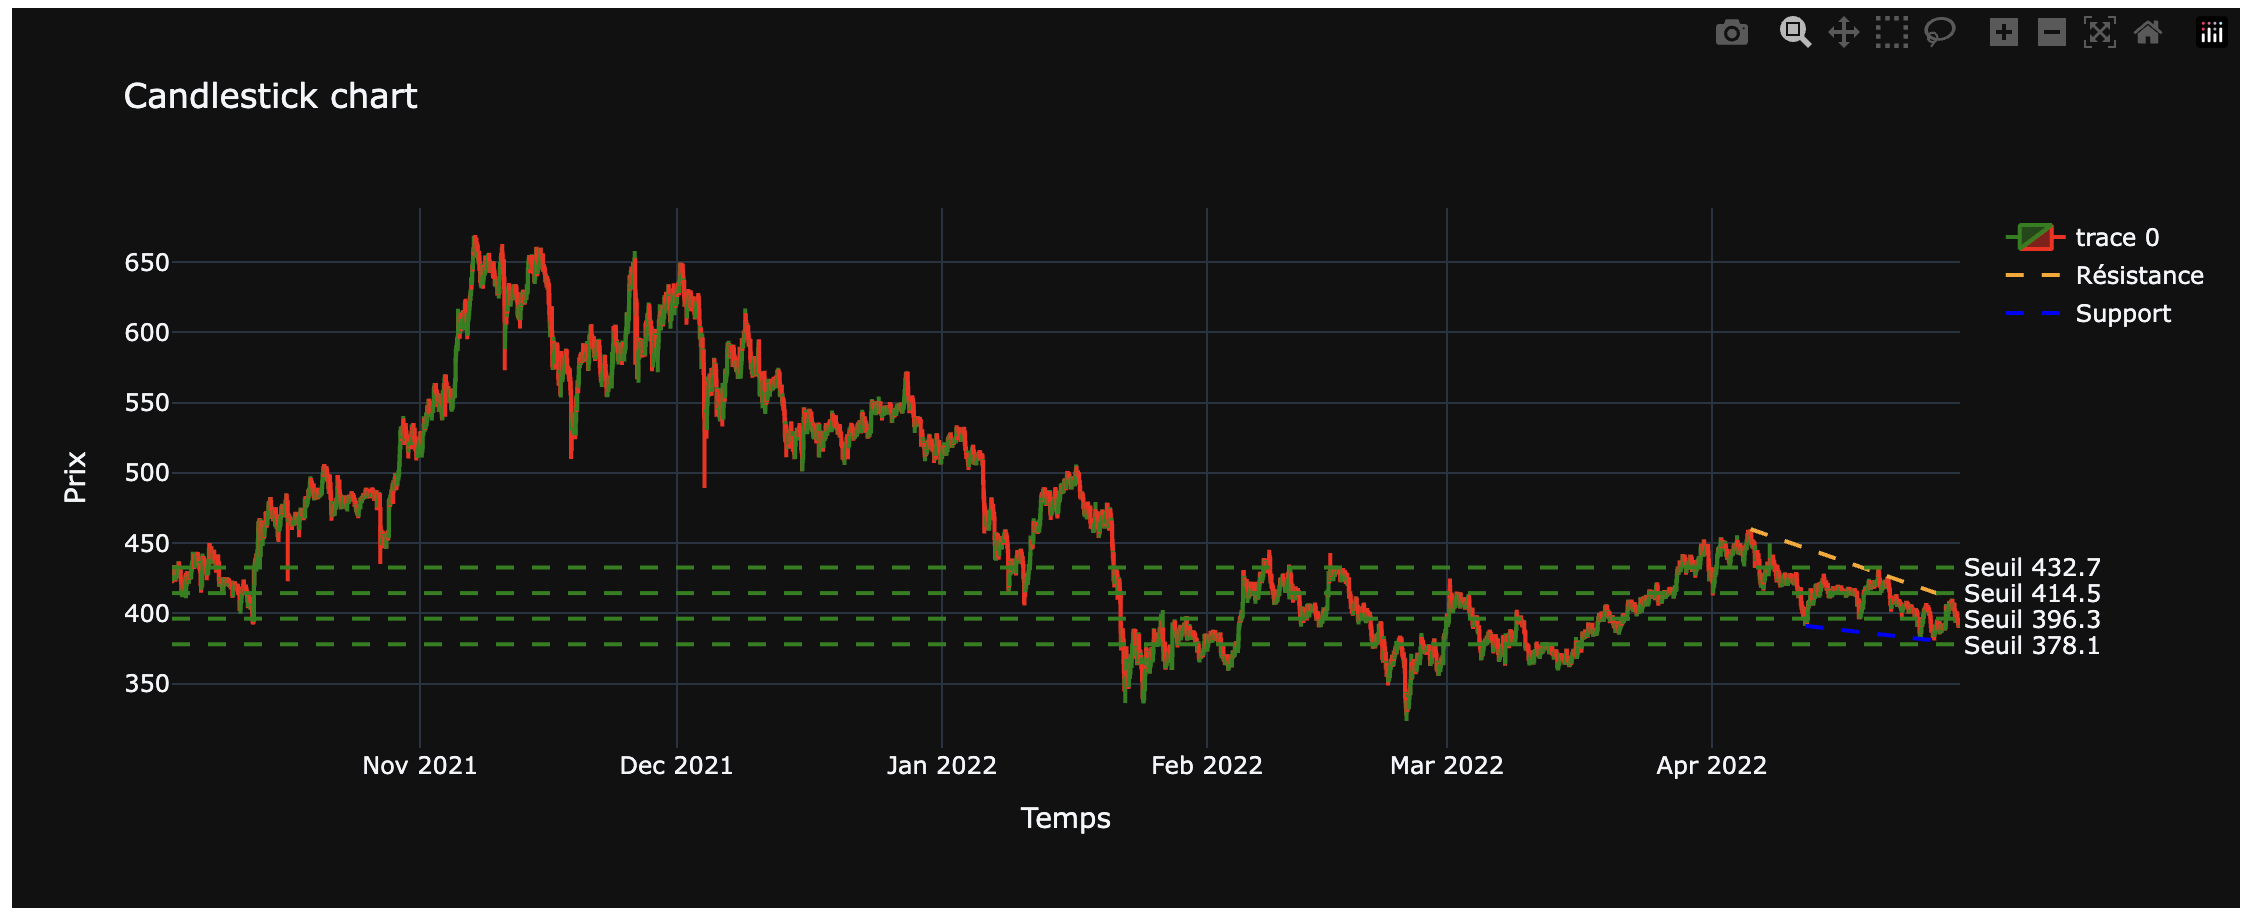

In [54]:
#plot_trend(BNB_USDT_zoom_week, best_psycho_threshold)
display(Image(filename='chart3.png'))

### Exploration 2: 
- We draw a constant and measure each time how many “candles rest” on the threshold, we proceed in this way on all the possible prices of the chosen frame, and then we compare the results with each other and keep the straight line or the n straight lines with the most candles according to a certain threshold. 

In [17]:
def find_pyscho_v2 (df, nb_seuil, cutting=100, tolerance=0.00005) :
    max_price=df['high'].max()
    min_price=df['low'].min()
    result={}
    for val in np.linspace(min_price, max_price, cutting) : 
        abs_tolerance = val * tolerance
        count = df[((df['high'] >= val - abs_tolerance) & (df['high'] <= val + abs_tolerance)) |
                   ((df['low'] >= val - abs_tolerance) & (df['low'] <= val + abs_tolerance))].shape[0]
        result[val] = count
    
    filtered_thresholds = {k: v for k, v in result.items() if v >= 3}

    best_psycho_threshold=sorted(filtered_thresholds.items(), key=lambda x: -x[1])[:nb_seuil]
    
    
    return best_psycho_threshold

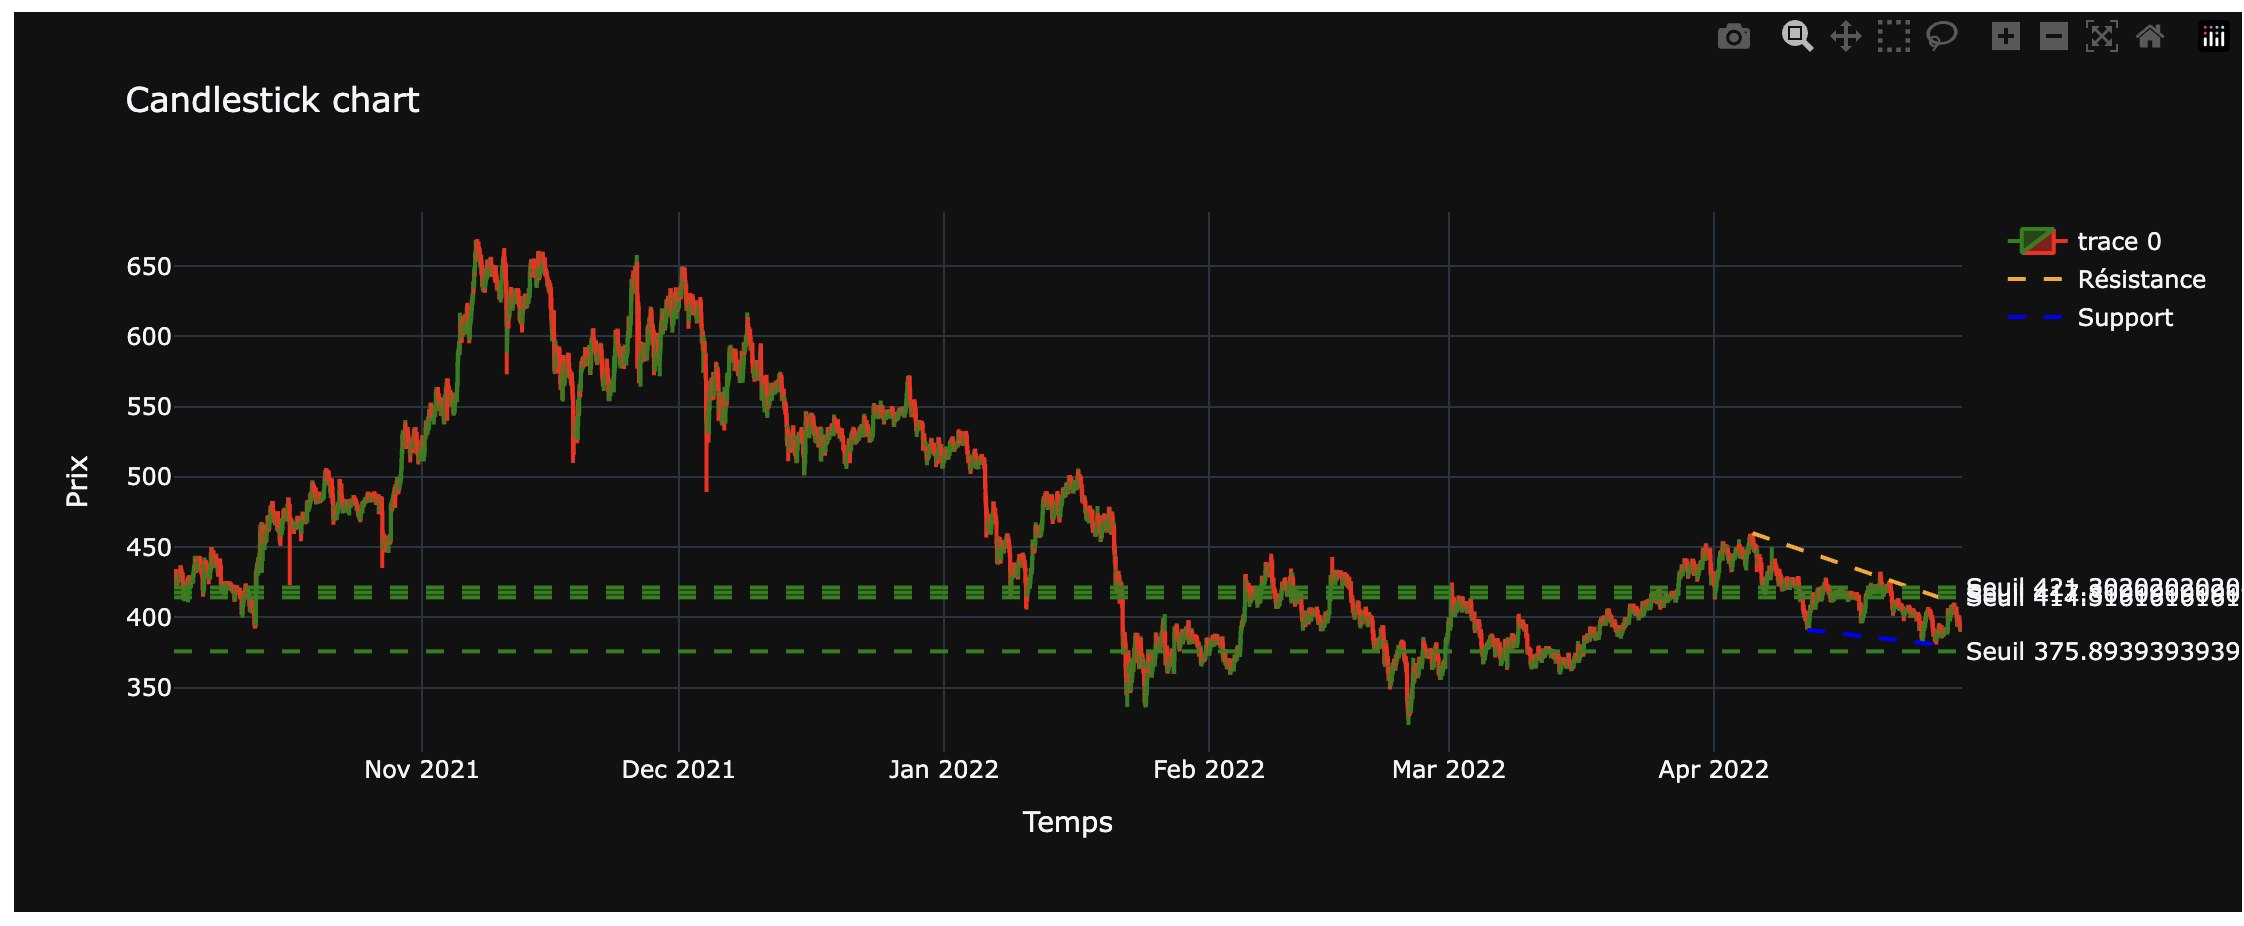

In [56]:
#plot_trend(BNB_USDT_zoom_week, find_pyscho_v2(BNB_USDT_zoom_week,4, 100))
display(Image(filename='chart4.png'))

### Exploration 3: 
- We draw a constant and measure each time how many “candles rest” on the threshold, we proceed in this way on the set of possible prices of the chosen frame, according to a certain step we keep the best candidate between each step, and we then compare the results between them and keep the straight line or the n straight lines with the most candles.  

In [19]:
import builtins

def find_pyscho_v3 (df, nb_seuil, cutting=100, tolerance=0.001) :
    max_price=df['high'].max()
    min_price=df['low'].min()
    result={}

    variance_high = df['high'].var()
    variance_low = df['low'].var()
    variance_total = variance_high + variance_low

    # Définition du "pas" basé sur la racine carrée de la variance totale
    pas = np.sqrt(variance_total)

    for val in np.linspace(min_price, max_price, cutting) : 
        abs_tolerance = val * tolerance
        count = df[((df['high'] >= val - abs_tolerance) & (df['high'] <= val + abs_tolerance)) |
                   ((df['low'] >= val - abs_tolerance) & (df['low'] <= val + abs_tolerance))].shape[0]
        result[val] = count
    
    filtered_thresholds = {k: v for k, v in result.items() if v >= 3}
    current_interval_start = min_price
    selected_thresholds = []

    while current_interval_start <= max_price:
        current_interval_end = current_interval_start + pas
        # Filtrer les constantes dans l'intervalle actuel
        candidates = [(val, count) for val, count in filtered_thresholds.items()
                      if current_interval_start <= val < current_interval_end]
        if candidates:
            # Sélectionner la constante avec le meilleur score dans l'intervalle
            best_candidate = builtins.max(candidates, key=lambda x: x[1])
            selected_thresholds.append(best_candidate)
            # Retirer les candidats sélectionnés pour éviter les doublons
            for candidate in candidates:
                filtered_thresholds.pop(candidate[0], None)
        # Passer à l'intervalle suivant"
        current_interval_start = current_interval_end

    best_psycho_threshold = sorted(selected_thresholds, key=lambda x: x[1], reverse=True)[:nb_seuil]
    
    return best_psycho_threshold

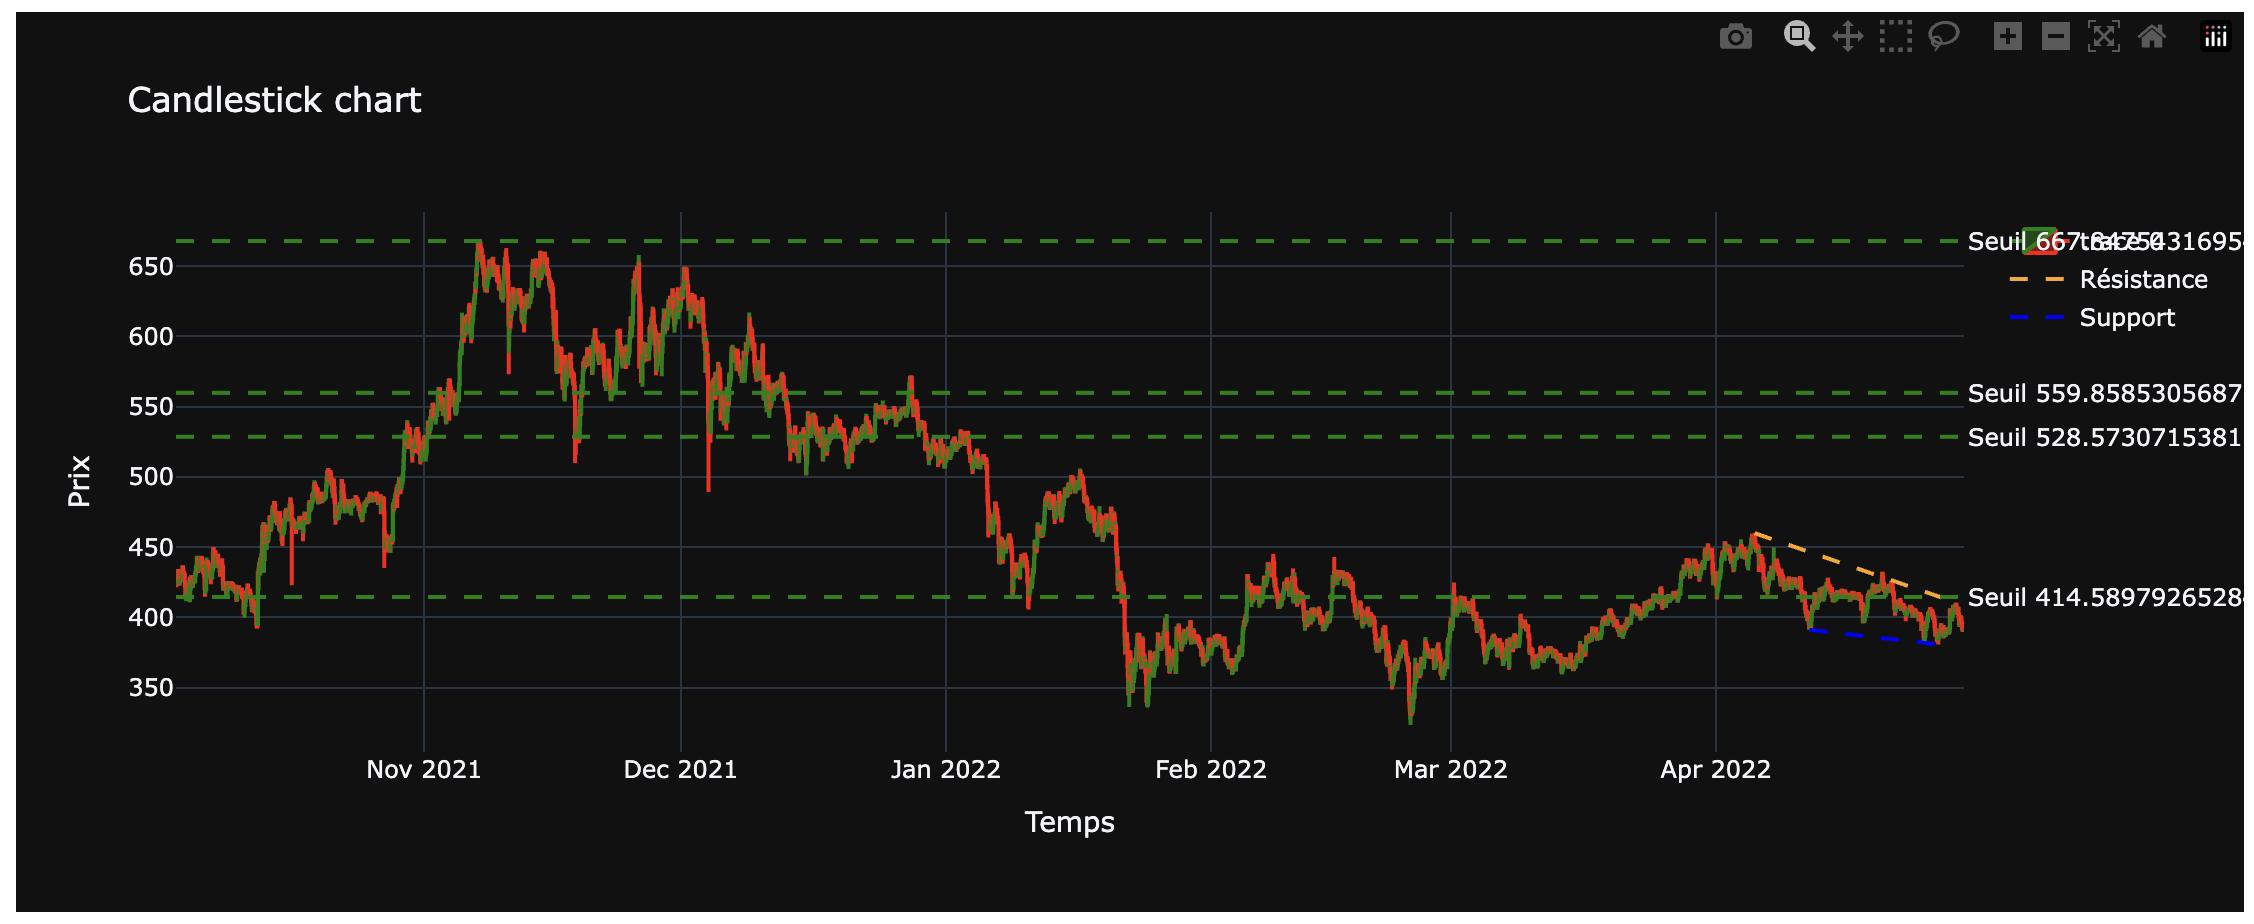

In [57]:
#plot_trend(BNB_USDT_zoom_week, find_pyscho_v3(BNB_USDT_zoom_week,10, 15000))
display(Image(filename='chart5.png'))

## VI. Global Trend

### Methodology: 
-  Determine peaks according to the prominence required 
-  Identify a pair of peaks 
-  Establish a slope and an intercept on this pair 
-  Calculate the noise between each peak and the defined line
-  Iterate for each pair of peaks and compare score 
-  Ditto for support (Determine “- peaks”)
-  Implement support and resistance in the data set for Data Visualization 

#### Visualization of the “peaks” identified during the various stages

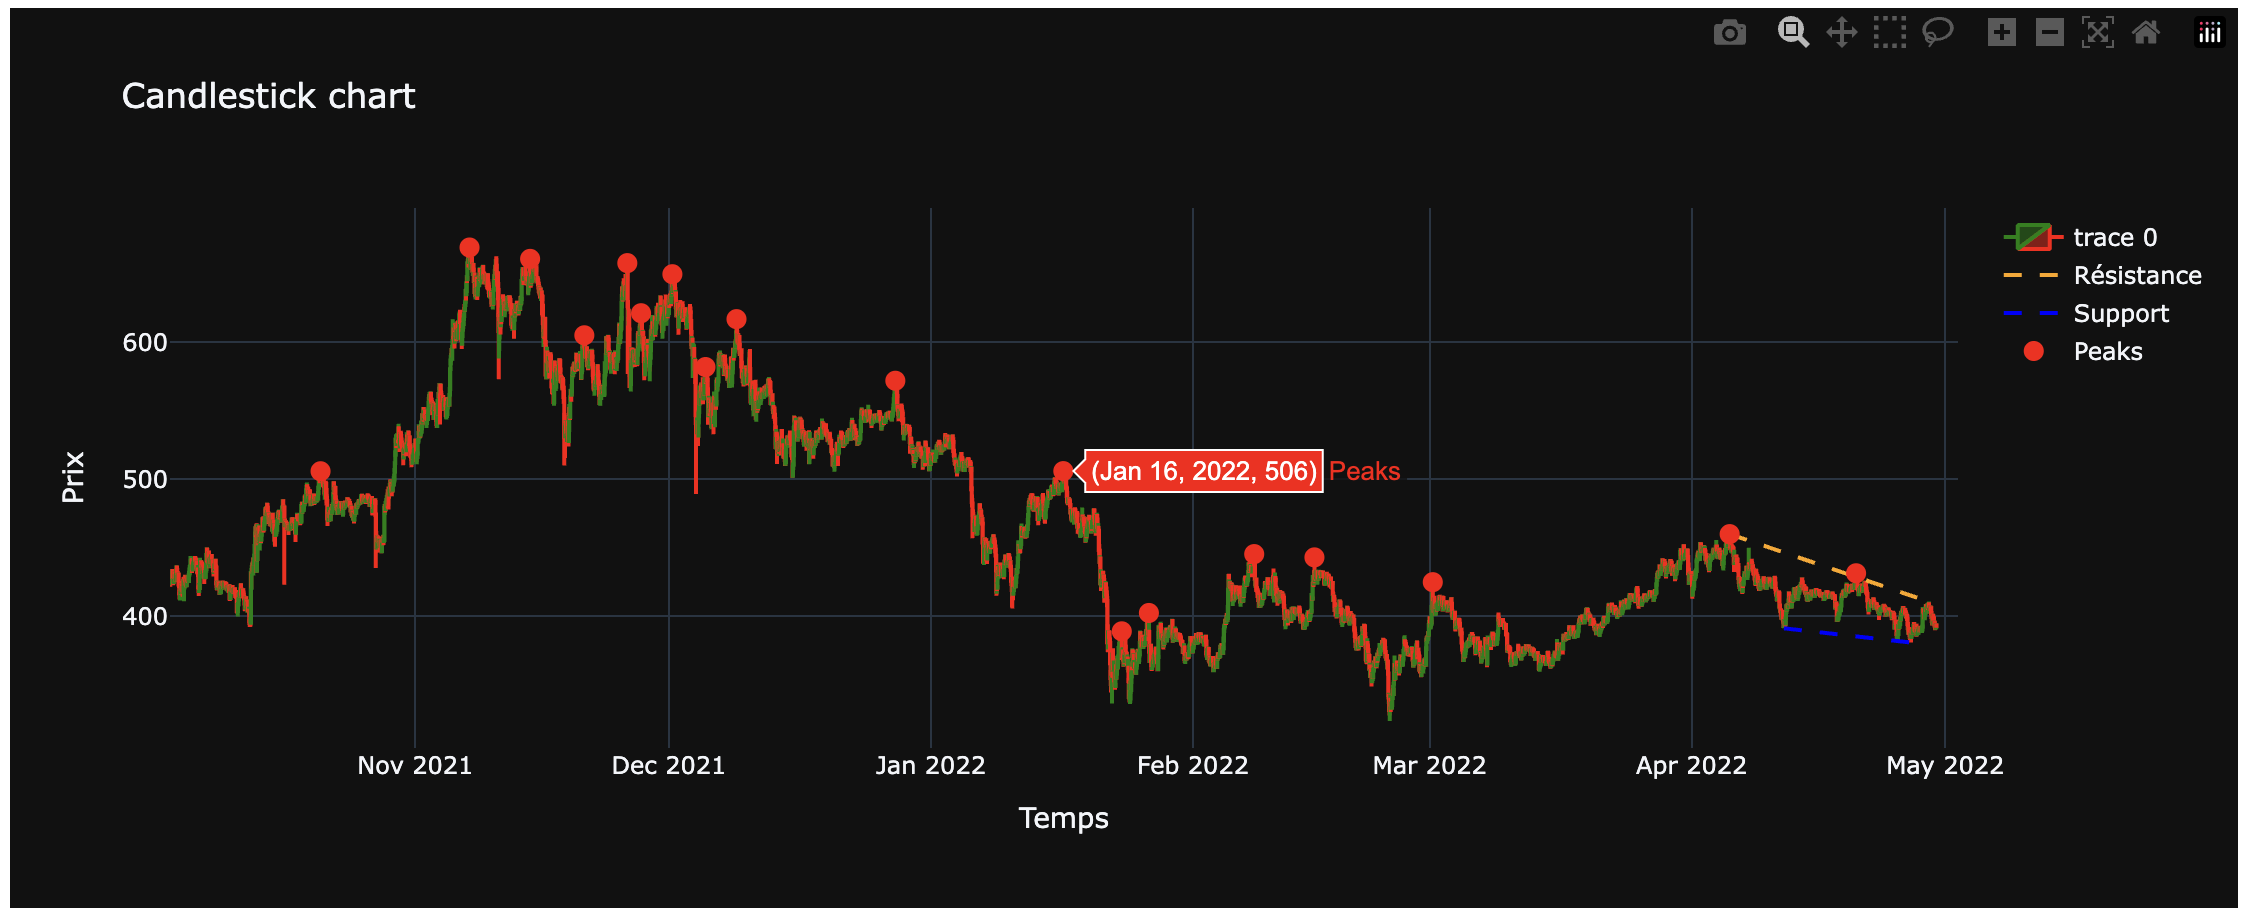

In [59]:
variance_high = BNB_USDT_zoom_week['high'].var()
variance_low = BNB_USDT_zoom_week['low'].var()
variance_total = variance_high + variance_low
pas = np.sqrt(variance_total) # Pour chaque niveau de prix dans l'intervalle [min_price, max_price], on compte le nombre de bougies traversant ce niveau.

max_peaks, _ = find_peaks(BNB_USDT_zoom_week['high'], prominence=pas*0.3)
min_peaks, _ = find_peaks(-BNB_USDT_zoom_week['low'], prominence=pas*0.3)
#plot_trend(BNB_USDT_zoom_week, max_peak=max_peaks)
display(Image(filename='chart6.png'))

## Definition of Global Trend:

- score_resistance: Evaluates the quality of a resistance line according to its proximity and the number of touches with high points.
- score_support: Evaluates the quality of a support line according to its proximity and the number of touches with low points.
- test_resistance_glob: Calculates a global resistance between two vertices and returns either the line or a validity score, depending on the mode.
- test_support_glob: Calculates a global support between two troughs and returns either the line or a validity score depending on the mode.
- global_trend :   Detects the most relevant global resistance and support from local price peaks.

In [22]:
def score_resistance (resist, data_, min_touch_dist=0.001) :

    # Initialization of score, tolerance and number of “touches"
    score_test=0
    tol=0.01
    score_test = 0
    touches = 0
    n = len(data_)

    for i in range(n):  # Loop over each point in the data series

        if data_[i] != 0:
            diff = data_[i] - resist[i] # Deviation between actual data and resistance


            if diff > resist[i] * tol:  # If data significantly exceeds resistance, it is considered invalid → very low score

                return -np.inf

            if abs(diff) <= min_touch_dist:
                touches += 1

            score_test += 1 / (1 + abs(diff)) # Increment the score: the closer the point is to the resistance, the greater its contribution.
 
    touch_bonus = 1 + touches / n       # Bonus proportional to the number of touches

    # Final score is amplified by trend length
    return score_test  * touch_bonus *(n**2)
    

def score_support (support, data_, min_touch_dist=0.001) :

    score_test = 0
    tol = 0.01
    touches = 0
    n = len(data_)

    for i in range(n):
        if data_[i] != 0:
            diff = support[i] - data_[i]  # inversion ici

            if diff > support[i] * tol:
                return -np.inf  # trop en dessous du support

            if abs(diff) <= min_touch_dist:
                touches += 1

            score_test += 1 / (1 + abs(diff))

    touch_bonus = 1 + touches / n
    return score_test * touch_bonus * (n ** 2)


def test_resistance_glob (y1, start, y2, end, df, max_peaks, first=None, last=None, find=None) :

    # Calculates the parameters (slope a and y-intercept b) of the line passing through two given points: (start, y1) and (end, y2)
    a, b =calc_line_params(start, y1, end, y2)
    resistance_glob= np.zeros(df.shape[0])
    x_range = np.arange(start, end + 1)
    resistance_glob[start:end + 1] = a * x_range + b

    if find is not None: # If you are in “find” mode, you only want to return the constructed line without scoring.
        return resistance_glob 
    
    benchmark= np.zeros(df.shape[0])
    for i in range(first,last+1) :      # Alternatively, prepare a benchmark vector based on real high points (max_peaks)
        benchmark[max_peaks[i]]= df['high'].iloc[max_peaks[i]]

    # Returns the score of the line by comparing the values of the line with the true price peaks
    return score_resistance(resistance_glob[start:end + 1], benchmark[start:end + 1])

def test_support_glob (y1, start, y2, end, df, min_peaks, first=None, last=None, find=None) :

    a, b =calc_line_params(start, y1, end, y2)
    support_glob= np.zeros(df.shape[0])
    x_range = np.arange(start, end + 1)
    support_glob[start:end + 1] = a * x_range + b

    if find is not None: 
        return support_glob 
    
    benchmark= np.zeros(df.shape[0])
    for i in range(first,last+1) :
        benchmark[min_peaks[i]]= df['low'].iloc[min_peaks[i]]

    return score_support(support_glob[start:end + 1], benchmark[start:end + 1])
    
def global_trend (df, learning_rate) : 

    # Step 1: Calculate “volatility” (variance) to determine an adaptive detection threshold
    variance_high = df['high'].var()
    variance_low = df['low'].var()
    variance_total = variance_high + variance_low
    pas = np.sqrt(variance_total)

    # Step 2: Detect peaks and troughs in the 'high' and 'low' columns
    max_peaks, _ = find_peaks(df['high'], prominence=pas*learning_rate)
    min_peaks, _ = find_peaks(-df['low'], prominence=pas*learning_rate)

    # Step 3: Check that there are enough peaks to build significant lines
    if len(max_peaks) < 2:
        raise ValueError("Pas assez de pics pour détecter une résistance globale.")

    if len(min_peaks) < 2:
       raise ValueError("Pas assez de pics pour détecter un support global.")

     # Step 4: Setting the best scores for resistance and support
    score_resistance={
        "score": -np.inf, 
        "First_peak" : 0,
        "Last_peak" : 0
        }
    
    score_support={
        "score":-np.inf, 
        "First_peak" : 0,
        "Last_peak" : 0
        }
    
    # Step 5: Loop through all vertex pairs to find the best resistance line
    for i in range(len(max_peaks)) :
        for peak in range(i+1, max_peaks.shape[0] ): 
            tmp=test_resistance_glob(df['high'].iloc[max_peaks[i]], max_peaks[i],  df['high'].iloc[max_peaks[peak]], max_peaks[peak], df, max_peaks, i, peak)
            if tmp>score_resistance["score"]:
                score_resistance["score"] = tmp
                score_resistance["First_peak"]= max_peaks[i]
                score_resistance["Last_peak"]= max_peaks[peak]

    # Ditto for troughs - we're looking for the best support line
    for i in range(len(min_peaks)):
        for peak in range(i+1, min_peaks.shape[0] ): 
            tmp=test_support_glob(df['low'].iloc[min_peaks[i]], min_peaks[i],  df['low'].iloc[min_peaks[peak]], min_peaks[peak], df, min_peaks, i, peak)
            if tmp>score_support["score"]:
                score_support["score"]=tmp
                score_support["First_peak"]= min_peaks[i]
                score_support["Last_peak"]= min_peaks[peak]
    
    # Step 7: Final construction of optimal lines (resistance and support) from selected peaks
    resistance_globale=test_resistance_glob(df['high'].iloc[score_resistance["First_peak"]], 
                                            score_resistance["First_peak"], 
                                            df['high'].iloc[score_resistance["Last_peak"]], 
                                            score_resistance["Last_peak"], 
                                            df, max_peaks, find=True)

    support_globale=test_support_glob(df['low'].iloc[score_support["First_peak"]], 
                                      score_support["First_peak"],  
                                      df['low'].iloc[score_support["Last_peak"]], 
                                      score_support["Last_peak"], 
                                      df, min_peaks, find=True)

    return resistance_globale, support_globale

In [23]:
resistance_global, support_global=global_trend(BNB_USDT_zoom_week, 0.15)

#### Implementation of the global trend in the data set for datavisualization 

In [24]:
BNB_USDT_zoom_week['resistance_global']=resistance_global
BNB_USDT_zoom_week['resistance_global']=BNB_USDT_zoom_week['resistance_global'].replace(0.0, np.nan)

BNB_USDT_zoom_week['support_global']=support_global
BNB_USDT_zoom_week['support_global']=BNB_USDT_zoom_week['support_global'].replace(0.0, np.nan)

#### Redefinition of chart and indicator implementation

In [27]:
def plot_trend_v2 (df, threshold=None, title="Candlestick chart"):
   
    fig = go.Figure(data=[go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['resistance'],
        mode='lines',
        line=dict(color='rgba(255, 220, 100, 1)'),
        name='Résistance'
    ))

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['support'],
        mode='lines',
        line=dict(color='rgba(255, 220, 100, 1)'),
        name='Support'
    ))

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['support_global'],
        mode='lines',
        line=dict(color='red'),
        name='Support'
    ))

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['resistance_global'],
        mode='lines',
        line=dict(color='red'),
        name='Résistance'
    ))

    if threshold!=None :
        for seuil in threshold :
            fig.add_hline(y=seuil[0], line=dict(color='#7FDBFF', dash='dash'), opacity=0.6, annotation_text=f'Seuil {seuil[0]}', annotation_position='right')
    fig.show()

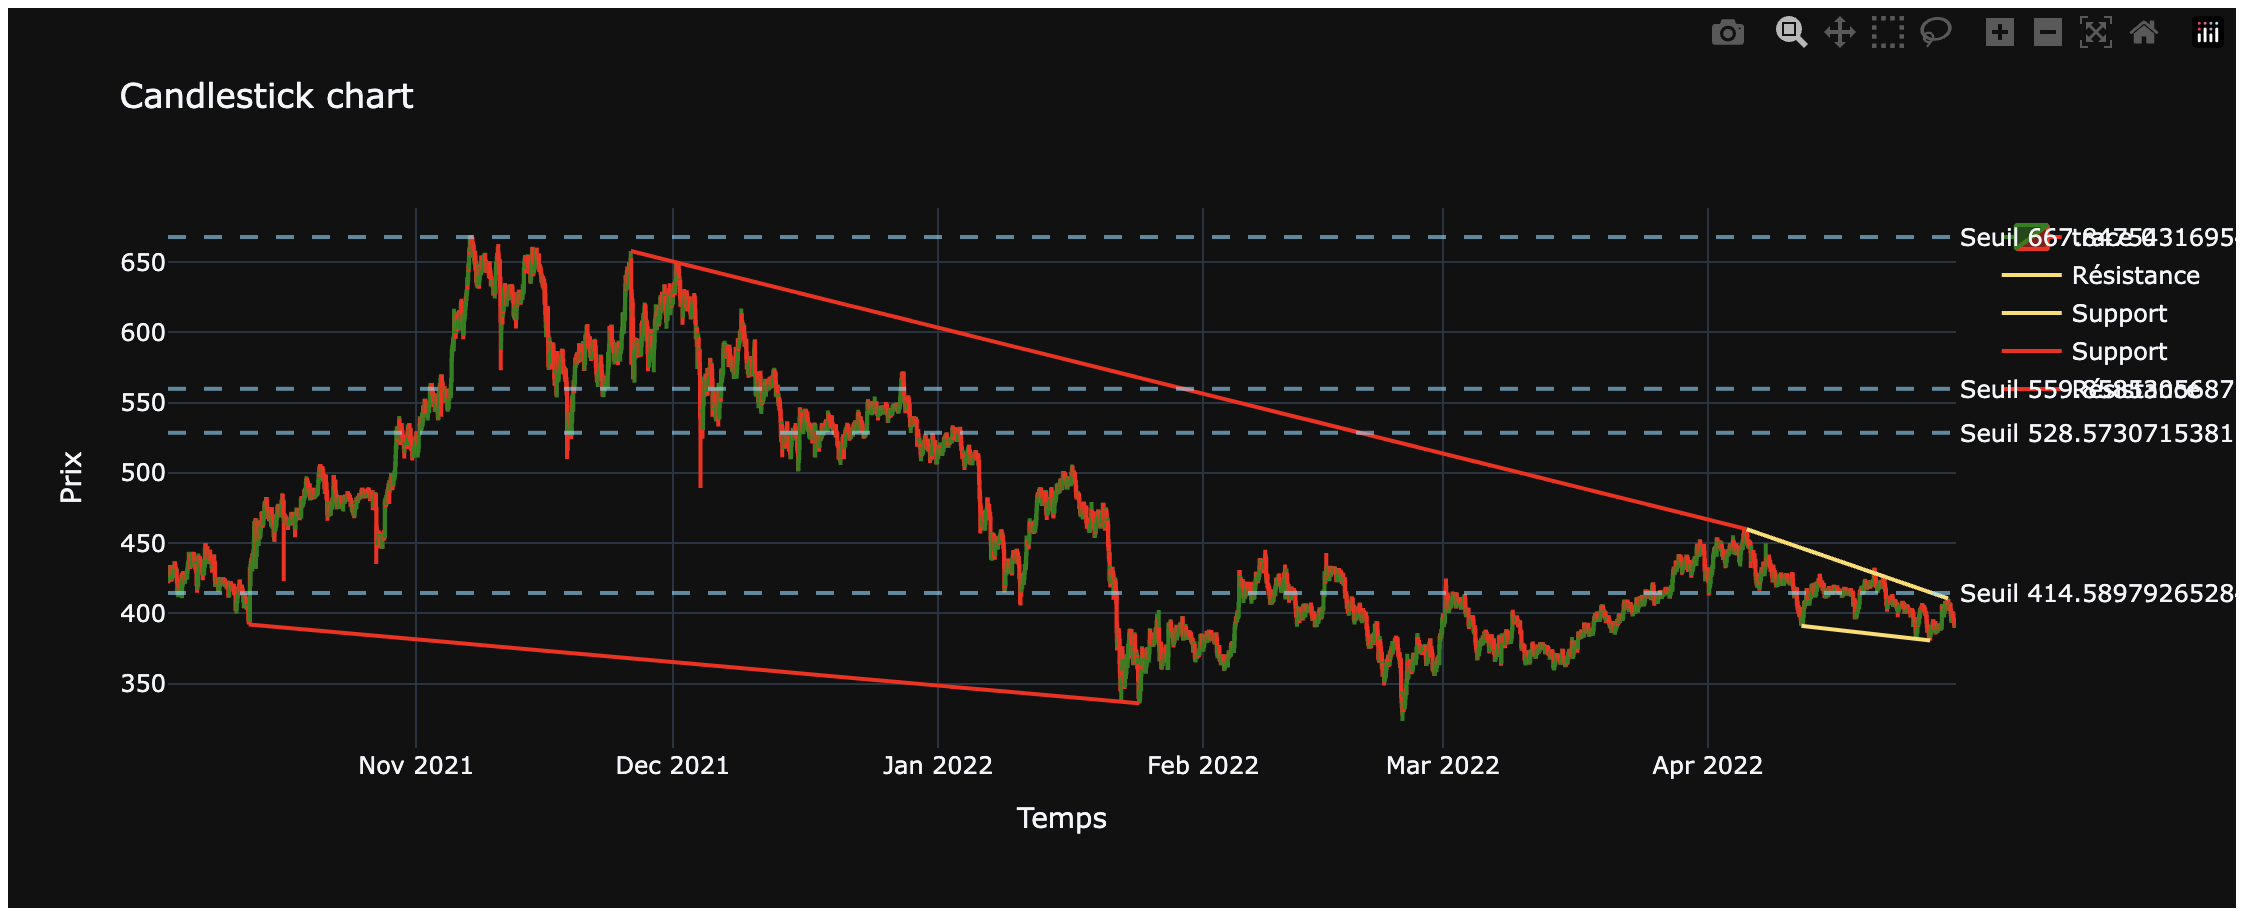

In [60]:
#plot_trend_v2(BNB_USDT_zoom_week, find_pyscho_v3(BNB_USDT_zoom_week,10, 15000))
display(Image(filename='chart7.png'))

## Conclusion 

- ### We have identified the global trend in red 

- ### We have identified an “internal” trend operating over a shorter timeframe

- ### We have been able to identify psychological price thresholds based on the past

# II. Trading strategy : 


#### The strategy is based on detecting bullish and bearish divergences, but with a ML model that is trained over past periods to detect whether a signal is “good” or “bad”, depending on whether certain patterns in the strategy's history have been assimilated to a stop loss or a take profit. 

#### The strategy is constructed as follows: 

#### Bearish divergence: 
- ##### We need to detect candle wicks that break out of the upper Bollinger band, which will be defined as “highs”. By comparing pairs of “highs”, respecting a certain spacing of 15 candles, if the connecting segment has a positive directing coefficient, then a candidate signal is registered. This candidate signal becomes a valid signal if, over the same period as the candidate signal, the segment linking the two highest RSI peaks has a negative directing coefficient. 
- ##### Finally, if the ML model authorizes this signal (no clues passed on to the precise characteristics of this signal, such as the directing coefficient, the absolute delta between the two “highest” peaks or others, are recognized), then this valid signal is a “SELL” downside trade which will be executed at the next crossing of the RSI at a value of 5O from below. 
- ##### A stop loss is set at the average of the upper bollinger bands over the last 24 hours, to avoid placing a trade in a “spike” due to volatility. And the take profit is placed progressively up to 2.5 times the difference between the entry and the stop loss.

#### Bullish divergence: 
- ##### We need to detect candle wicks that break out of the lower Bollinger band, which will be defined as “Lows”. By comparing pairs of “Lows”, respecting a certain spacing of 15 candles, if the connecting segment has a positive directrix, then a candidate signal is registered. This candidate signal becomes a valid signal if, over the same period as the candidate signal, the segment connecting the two lowest RSI peaks has a positive directing coefficient. 
- ##### Finally, if the ML model authorizes this signal (no clues transmitted on the precise characteristics of this signal, such as the directing coefficient, the absolute delta between the two highest peaks or others, are recognized), then this valid signal is a downward “BUY” trade which will be executed the next time the RSI crosses a value of 5O from below. 
- ##### A stop loss is set at the average of the lower bollinger bands over the last 24 hours, to avoid placing a trade in a “spike” due to volatility. And the take profit is set progressively up to 2.5 times the difference between the entry and the stop loss.

## Creation of technical indicators :  

- RSI 
- RSI interpretation 
- MACD
- Bollinger Bands

In [29]:
def compute_rsi(prices, window=5):
    delta = prices.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Moyenne mobile sur window
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    avg_loss = avg_loss.replace(0, 0.0001)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def interpret_rsi(rsi_value):
    if pd.isna(rsi_value):
        return None
    if rsi_value > 70:
        return "sell"
    elif rsi_value < 30:
        return "buy"
    else:
        return "neutral"

def compute_macd(df, short_window=12, long_window=26, signal_window=9):
    ema_short = df['mid_price'].ewm(span=short_window, adjust=False).mean()
    ema_long = df['mid_price'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = ema_short - ema_long
    df['MACD_signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']
    return df

def compute_bollinger_bands(df, window=20, num_std=2):

    df['Bollinger_Middle'] = df['mid_price'].rolling(window=window).mean()
    sigma = df['mid_price'].rolling(window=window).std()

    df['Bollinger_Upper'] = df['Bollinger_Middle'] + num_std * sigma
    df['Bollinger_Lower'] = df['Bollinger_Middle'] - num_std * sigma
    
    return df



## Creating plots with technical indicators :  

- RSI 
- MACD
- Bollinger Bands
- All indicators at once

In [30]:
def plot_candlestick_with_rsi(df, title="Candlestick chart + RSI", window=5):
    if 'RSI_value' not in df.columns:
        df['RSI_value'] = compute_rsi(df['mid_price'], window=window)

    fig = make_subplots(
        rows=2, cols=1, 
        shared_xaxes=True,
        vertical_spacing=0.13,
        row_heights=[0.7, 0.3],
        subplot_titles=(title, "RSI")
    )

    # Bougies
    fig.add_trace(go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Prix'
    ), row=1, col=1)

    # RSI
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['RSI_value'],
        mode='lines',
        line=dict(color='blue'),
        name='RSI'
    ), row=2, col=1)

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title="Temps",
        yaxis_title="Prix",
        template='plotly_dark',
        xaxis_rangeslider_visible=False,
        height=500
    )

    fig.add_hline(y=70, line=dict(color='red', dash='dash'), row=2, col=1)
    fig.add_hline(y=30, line=dict(color='green', dash='dash'), row=2, col=1)

    fig.show()

def plot_candlestick_with_bollinger(df, title="Candlestick + Bollinger Bands"):
    fig = go.Figure()

    fig = make_subplots(
        rows=2, cols=1, 
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
        subplot_titles=(title, "Volume d'échange")
    )

    # Bougies
    fig.add_trace(go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Prix'
    ), row=1, col=1)

    # Bandes de Bollinger
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['Bollinger_Upper'],
        line=dict(color='lightblue', width=1),
        name='Upper Band'
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['Bollinger_Middle'],
        line=dict(color='white', width=1, dash='dot'),
        name='Middle Band'
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['Bollinger_Lower'],
        line=dict(color='lightblue', width=1),
        name='Lower Band'
    ), row=1, col=1)


    # Volume en histogramme
    fig.add_trace(go.Bar(
        x=df['open_time'],
        y=df['volume'],
        marker_color='gray',
        name='Volume',
        opacity=0.6
    ), row=2, col=1)
    
    fig.update_layout(
        title=title,
        template='plotly_dark',
        xaxis_title="Temps",
        yaxis_title="Prix",
        xaxis_rangeslider_visible=False,
        height=500
    )

    
    fig.show()

def plot_candlestick_with_macd(df, title="Candlestick chart + MACD"):

    fig = make_subplots(
        rows=2, cols=1, 
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
        subplot_titles=(title, "MACD")
    )

    # Bougies
    fig.add_trace(go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Prix'
    ), row=1, col=1)

    # MACD Line
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['MACD'],
        mode='lines',
        line=dict(color='white'),
        name='MACD'
    ), row=2, col=1)

    # Signal Line
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['MACD_signal'],
        mode='lines',
        line=dict(color='red', dash='dot'),
        name='Signal'
    ), row=2, col=1)

    # Histogramme
    fig.add_trace(go.Bar(
        x=df['open_time'],
        y=df['MACD_histogram'],
        marker_color='white',
        name='Histogram'
    ), row=2, col=1)

    # Layout général
    fig.update_layout(
        title=title,
        template='plotly_dark',
        xaxis_rangeslider_visible=False,
        height=500
    )

    fig.show()
    
def plot_trend_vfinal_2(df, threshold=None, window=5, title="Candlestick chart"):
    # Calculer RSI si pas déjà fait
    if 'RSI_value' not in df.columns:
        df['RSI_value'] = compute_rsi(df['mid_price'], window=window)
    
    # Création de la figure avec 5 sous-graphes
    fig = make_subplots(
        rows=4, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.5, 0.2, 0.15, 0.15,],
        subplot_titles=(title, "RSI", "MACD", "Volume échangé")
    )

    # Bougies (Row 1)
    fig.add_trace(go.Candlestick(
        x=df['open_time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Prix'
    ), row=1, col=1)

    # Bandes de Bollinger directement sur les bougies
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['Bollinger_Upper'],
        line=dict(color='lightblue'),
        name='Upper Band'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['Bollinger_Middle'],
        line=dict(color='white', dash='dot'),
        name='Middle Band'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['Bollinger_Lower'],
        line=dict(color='lightblue'),
        name='Lower Band'
    ), row=1, col=1)

    # Ajout Résistance / Support (Row 1)
    if 'resistance' in df.columns:
        fig.add_trace(go.Scatter(
            x=df['open_time'],
            y=df['resistance'],
            mode='lines',
            line=dict(color='yellow'),
            name='Résistance'
        ), row=1, col=1)

    if 'support' in df.columns:
        fig.add_trace(go.Scatter(
            x=df['open_time'],
            y=df['support'],
            mode='lines',
            line=dict(color='yellow'),
            name='Support'
        ), row=1, col=1)
    '''
    if 'support_global' in df.columns:
        fig.add_trace(go.Scatter(
            x=df['open_time'],
            y=df['support_global'],
            mode='lines',
            line=dict(color='red'),
            name='Support Global'
        ), row=1, col=1)

    if 'resistance_global' in df.columns:
        fig.add_trace(go.Scatter(
            x=df['open_time'],
            y=df['resistance_global'],
            mode='lines',
            line=dict(color='red'),
            name='Résistance Global'
        ), row=1, col=1)
    
    if threshold is not None:
        for seuil in threshold:
            fig.add_hline(y=seuil[0], line=dict(color='#7FDBFF', dash='dash'), opacity=0.6,
                          annotation_text=f'Seuil {seuil[0]}', annotation_position='right', row=1, col=1)
    '''
    # RSI (Row 2)
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['RSI_value'],
        mode='lines',
        line=dict(color='blue'),
        name='RSI'
    ), row=2, col=1)

    # Seuils RSI
    fig.add_hline(y=70, line=dict(color='red', dash='dash'), row=2, col=1)
    fig.add_hline(y=30, line=dict(color='green', dash='dash'), row=2, col=1)

    # MACD + Signal + Histogramme (Row 3)
    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['MACD'],
        mode='lines',
        line=dict(color='white'),
        name='MACD'
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        x=df['open_time'],
        y=df['MACD_signal'],
        mode='lines',
        line=dict(color='red', dash='dot'),
        name='Signal'
    ), row=3, col=1)

    fig.add_trace(go.Bar(
        x=df['open_time'],
        y=df['MACD_histogram'],
        marker_color='lightblue',
        name='Histogramme MACD'
    ), row=3, col=1)


    # Volume (Row 5)
    fig.add_trace(go.Bar(
        x=df['open_time'],
        y=df['volume'],
        marker_color='red',
        name='Volume',
        opacity=0.6
    ), row=4, col=1)

    # Layout final
    fig.update_layout(
        title=title,
        template='plotly_dark',
        xaxis_rangeslider_visible=False,
        height=1000
    )

    fig.update_yaxes(title_text="Prix", row=1, col=1)
    fig.update_yaxes(title_text="RSI", row=2, col=1)
    fig.update_yaxes(title_text="MACD", row=3, col=1)
    fig.update_yaxes(title_text="Volume", row=4, col=1)
    fig.update_yaxes(title_text="Volume", type="log", row=4, col=1)
    #fig.update_yaxes(title_text="Volume", row=5, col=1)

    fig.show()


## Choice of strategy application period 

#### Warning: the dynamism of the peridoes is not yet automated, so you need to be careful if you touch the test periods. 

In [39]:
df = BNB_USDT[
    (BNB_USDT['open_time'] >= '2021-03-06') & 
    (BNB_USDT['open_time'] < '2022-03-01')
]

# I add the indicators that will be useful for the future to my dataframe 
df['mid_price']=(df['low']+df['high'])/2
df['RSI_value'] = compute_rsi(df['mid_price'], window=72)
df['RSI_signal'] = df['RSI_value'].apply(interpret_rsi)
df=compute_macd(df)
df=compute_bollinger_bands(df)

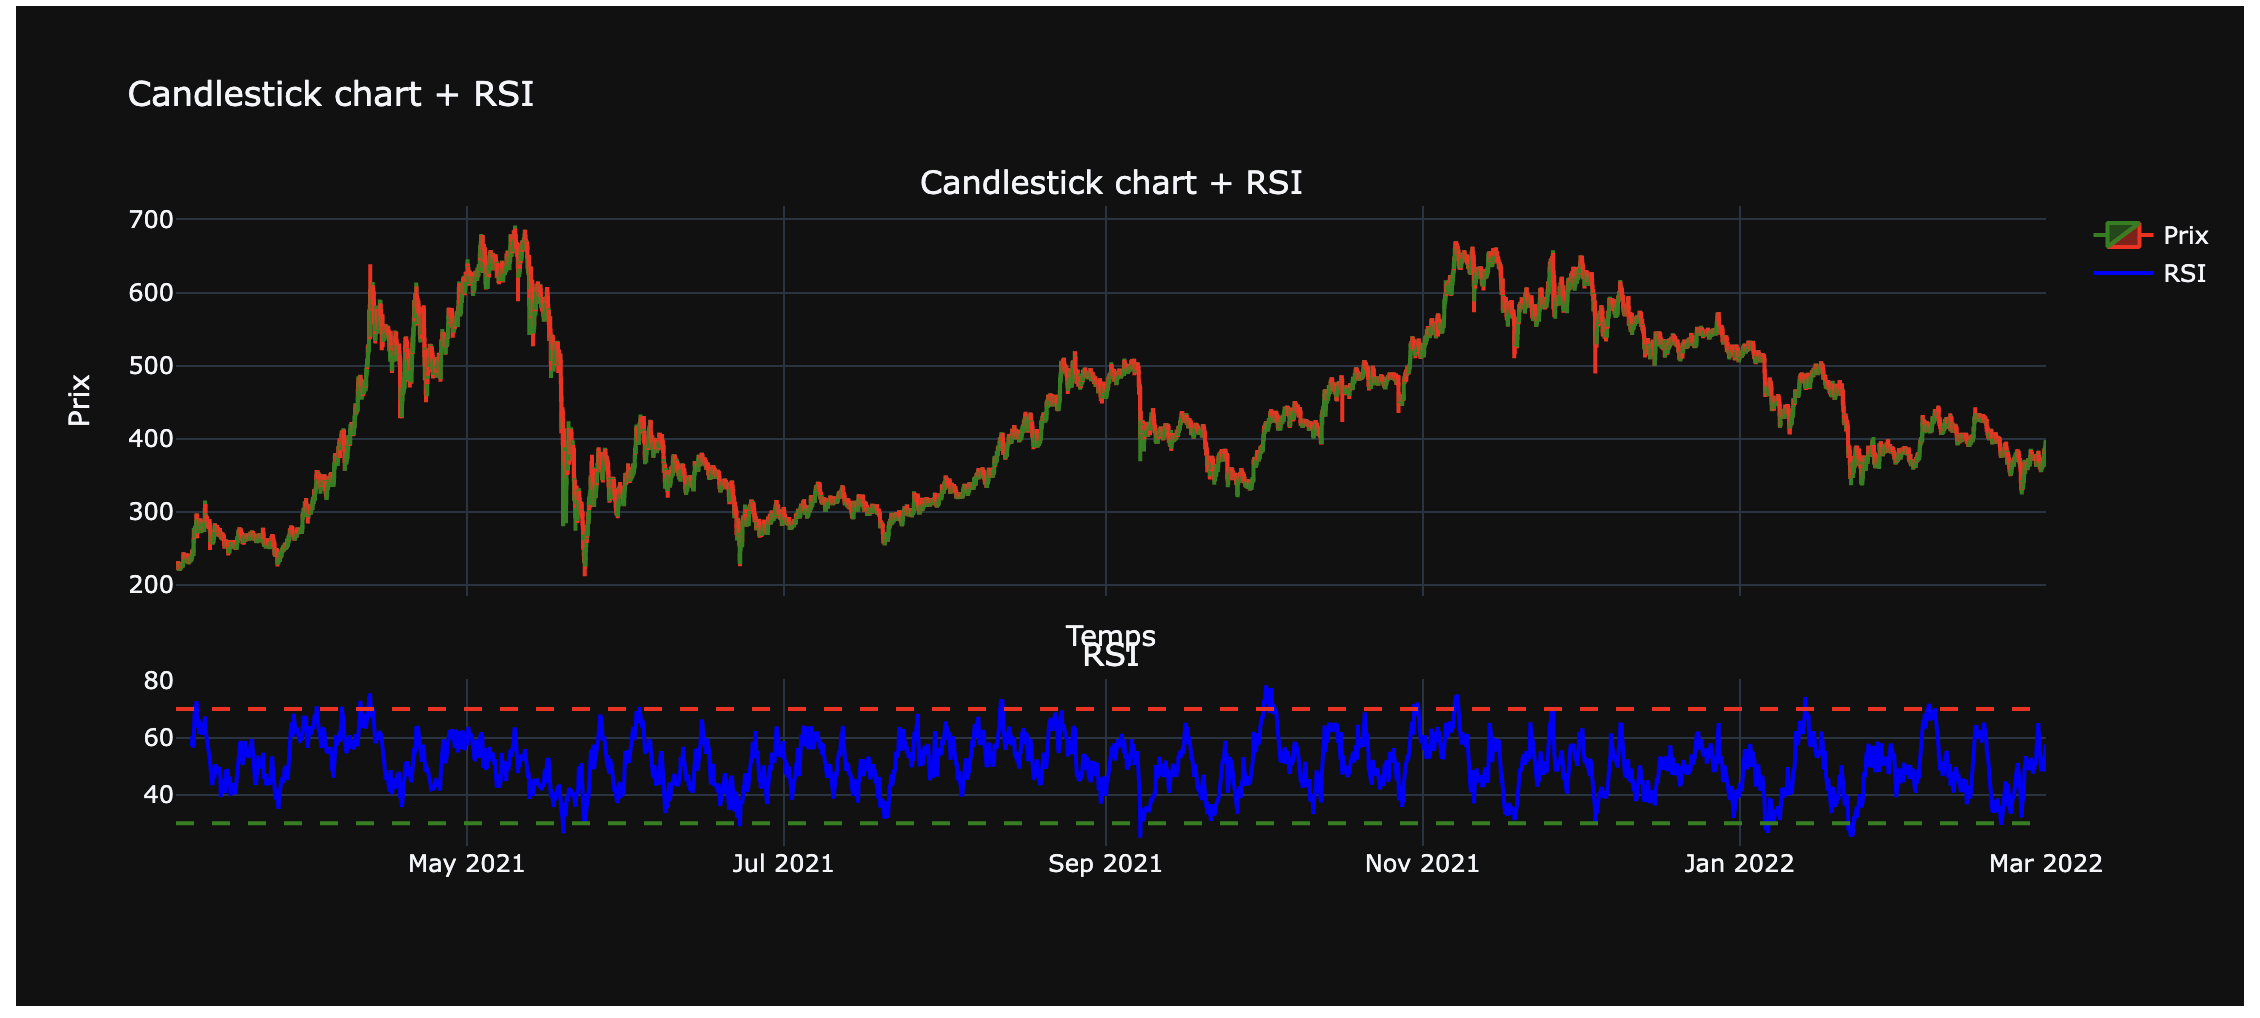

In [61]:
# plot_candlestick_with_rsi(df)
display(Image(filename='chart8.png'))

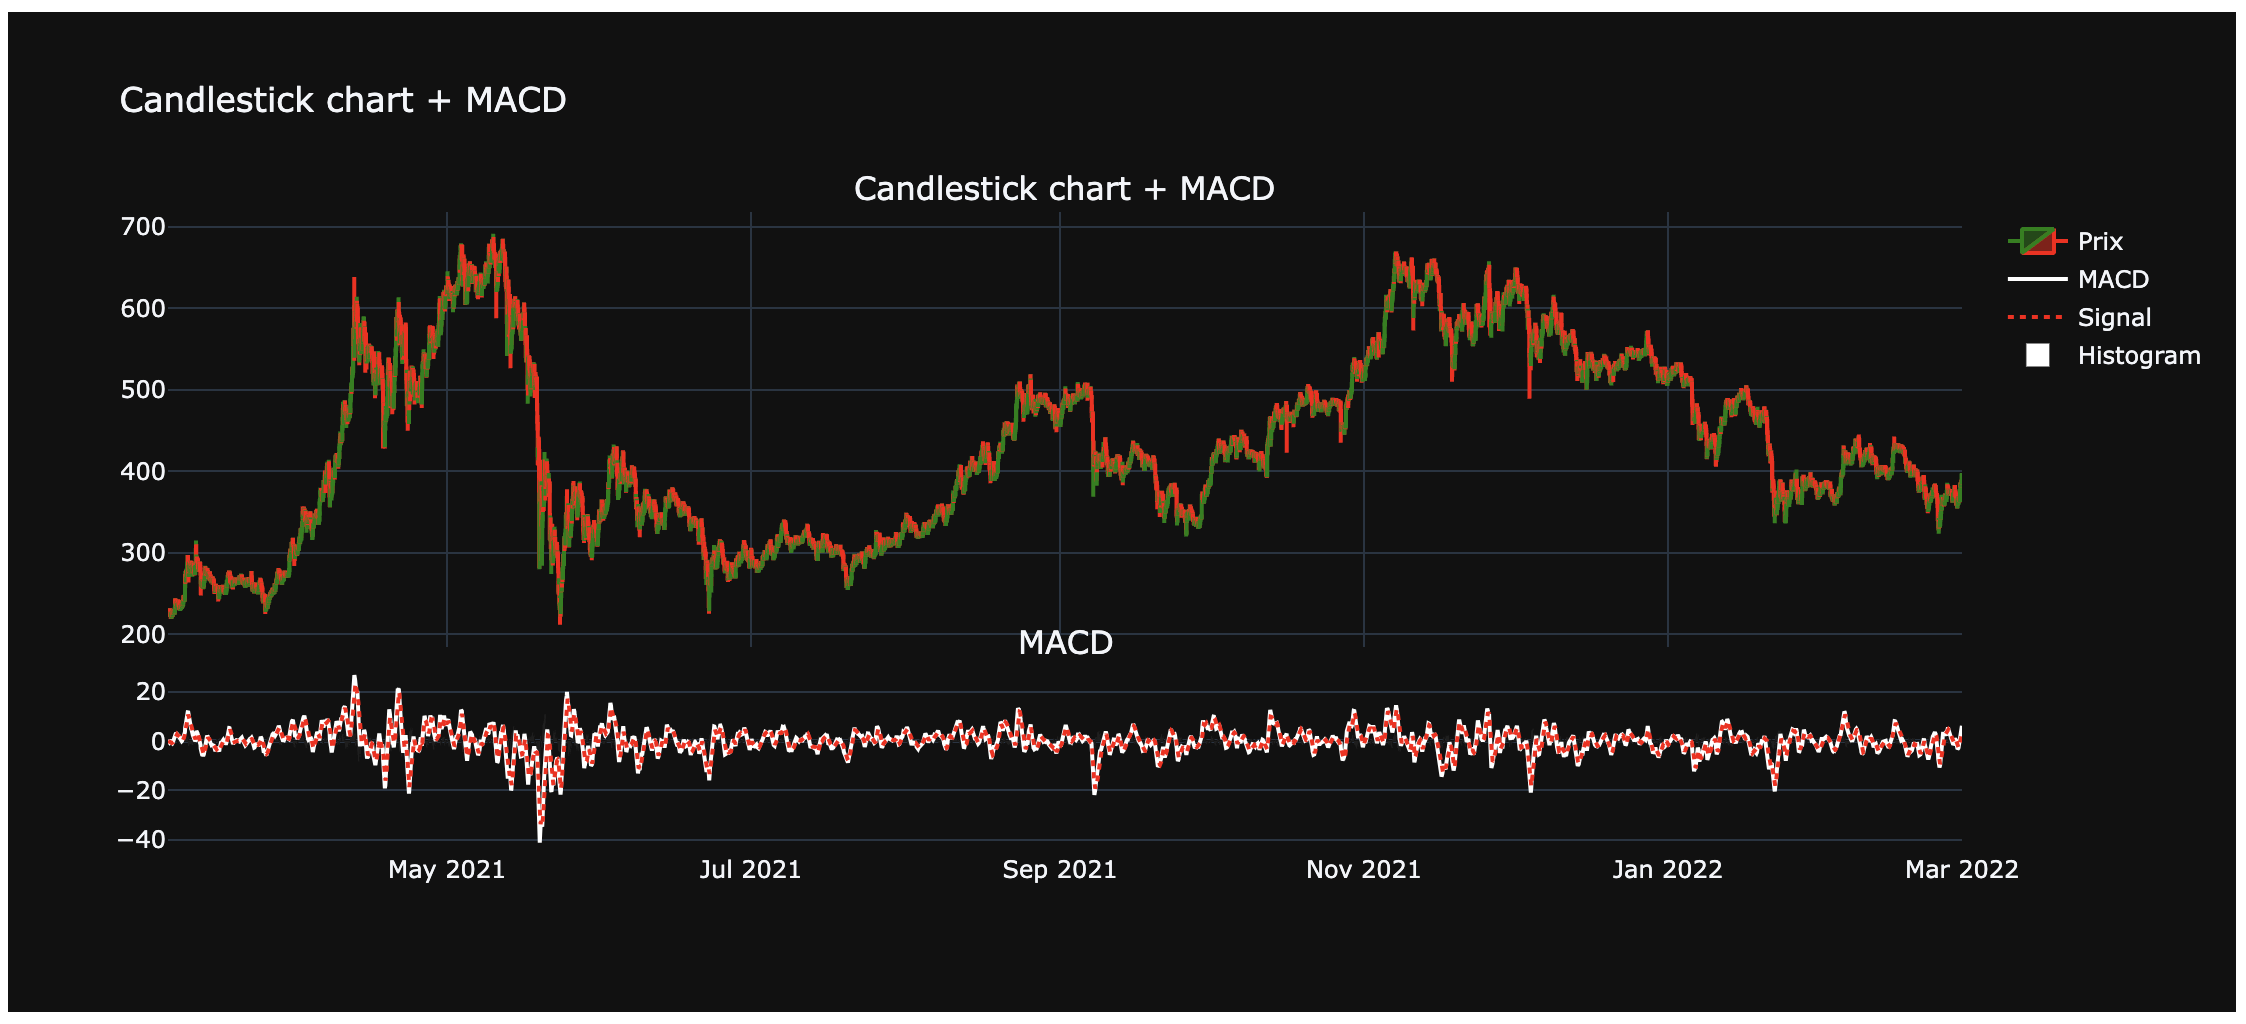

In [62]:
#plot_candlestick_with_macd(df)
display(Image(filename='chart9.png'))

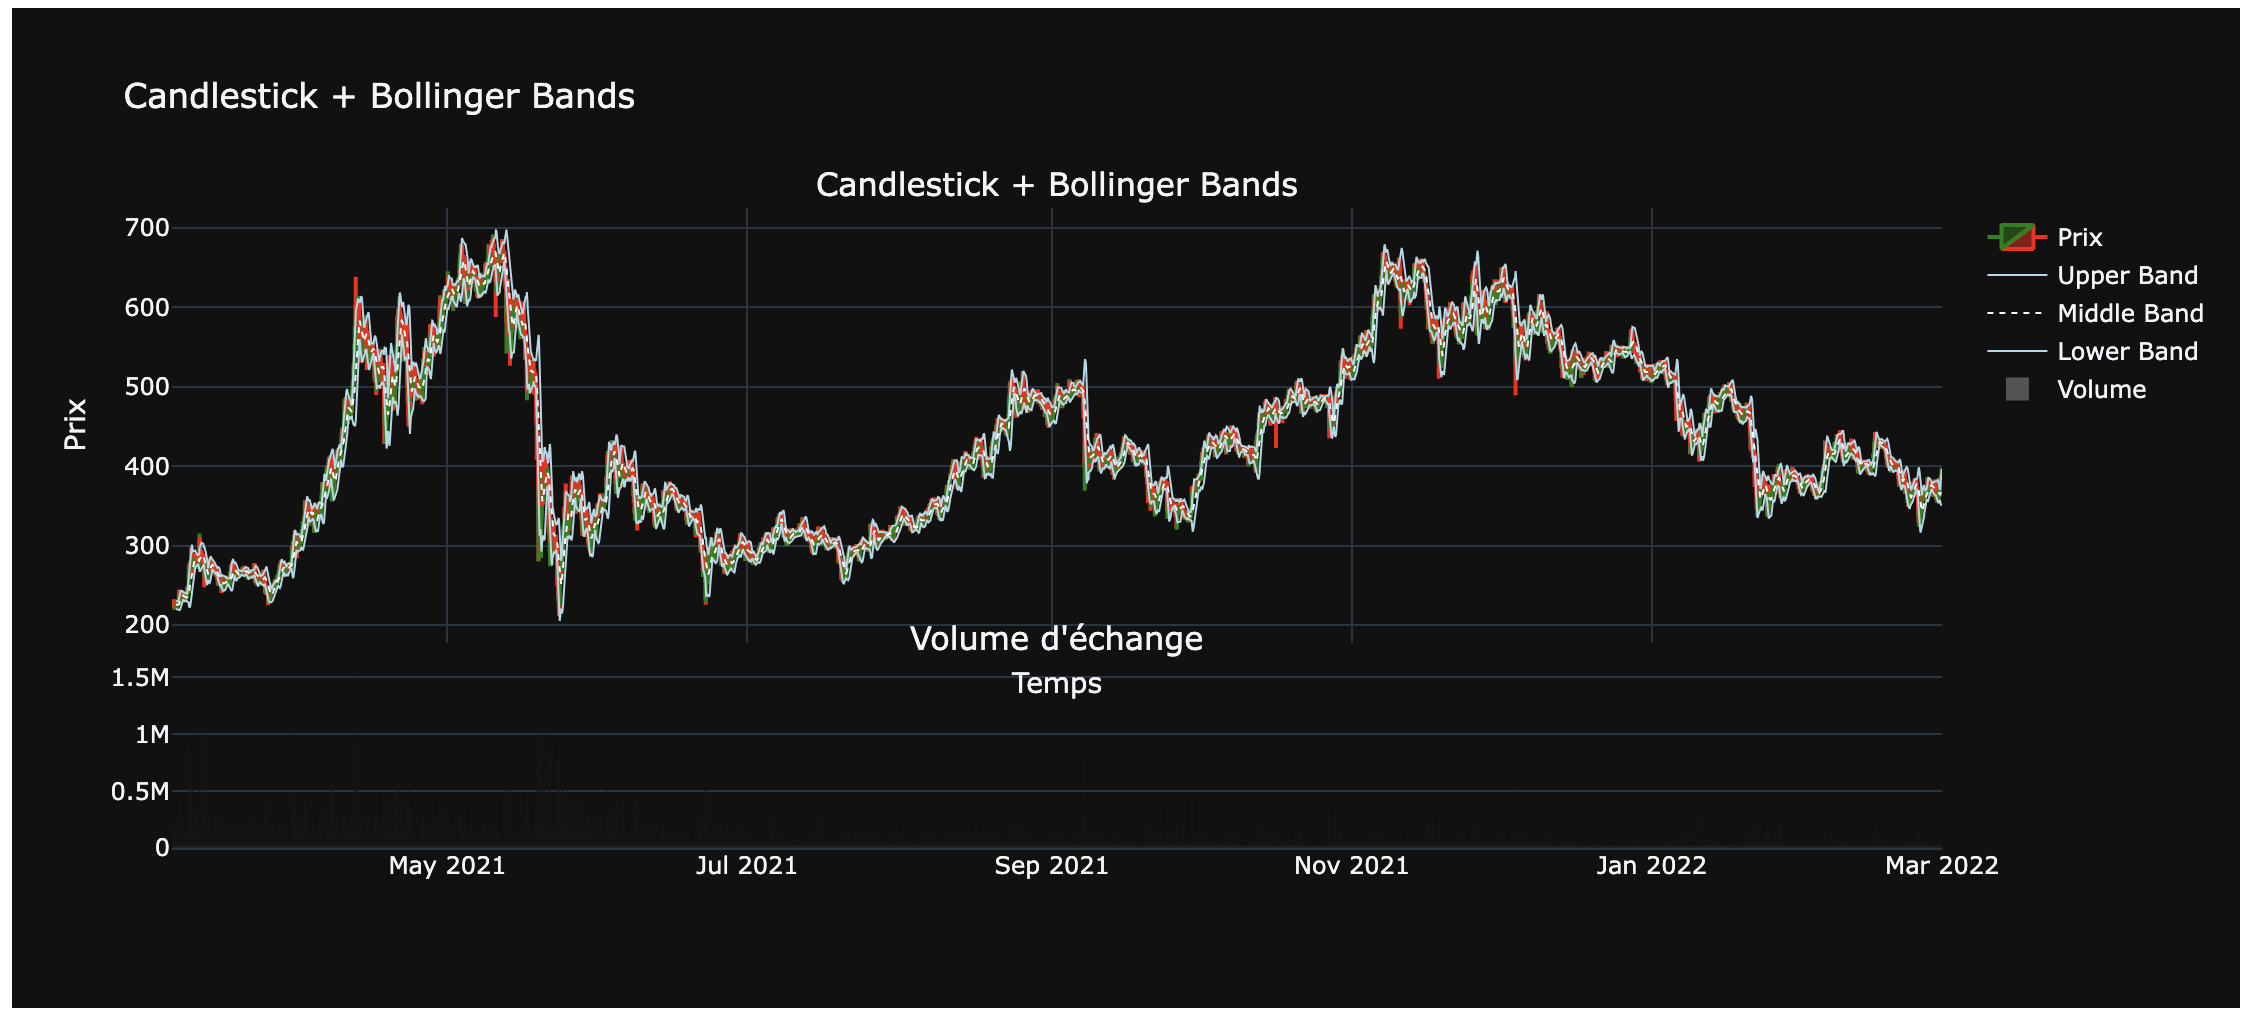

In [63]:
#plot_candlestick_with_bollinger(df)
display(Image(filename='chart10.png'))

In [40]:
df_BNB= BNB_USDT[
    (BNB_USDT['open_time'] >= '2018-01-06') & 
    (BNB_USDT['open_time'] < '2021-10-01')
]
df_BNB['mid_price']=(df_BNB['low']+df_BNB['high'])/2
df_BNB['RSI_value'] = compute_rsi(df_BNB['mid_price'], window=72)
df_BNB['RSI_signal'] = df_BNB['RSI_value'].apply(interpret_rsi)
df_BNB=compute_macd(df_BNB)
df_BNB=compute_bollinger_bands(df_BNB)

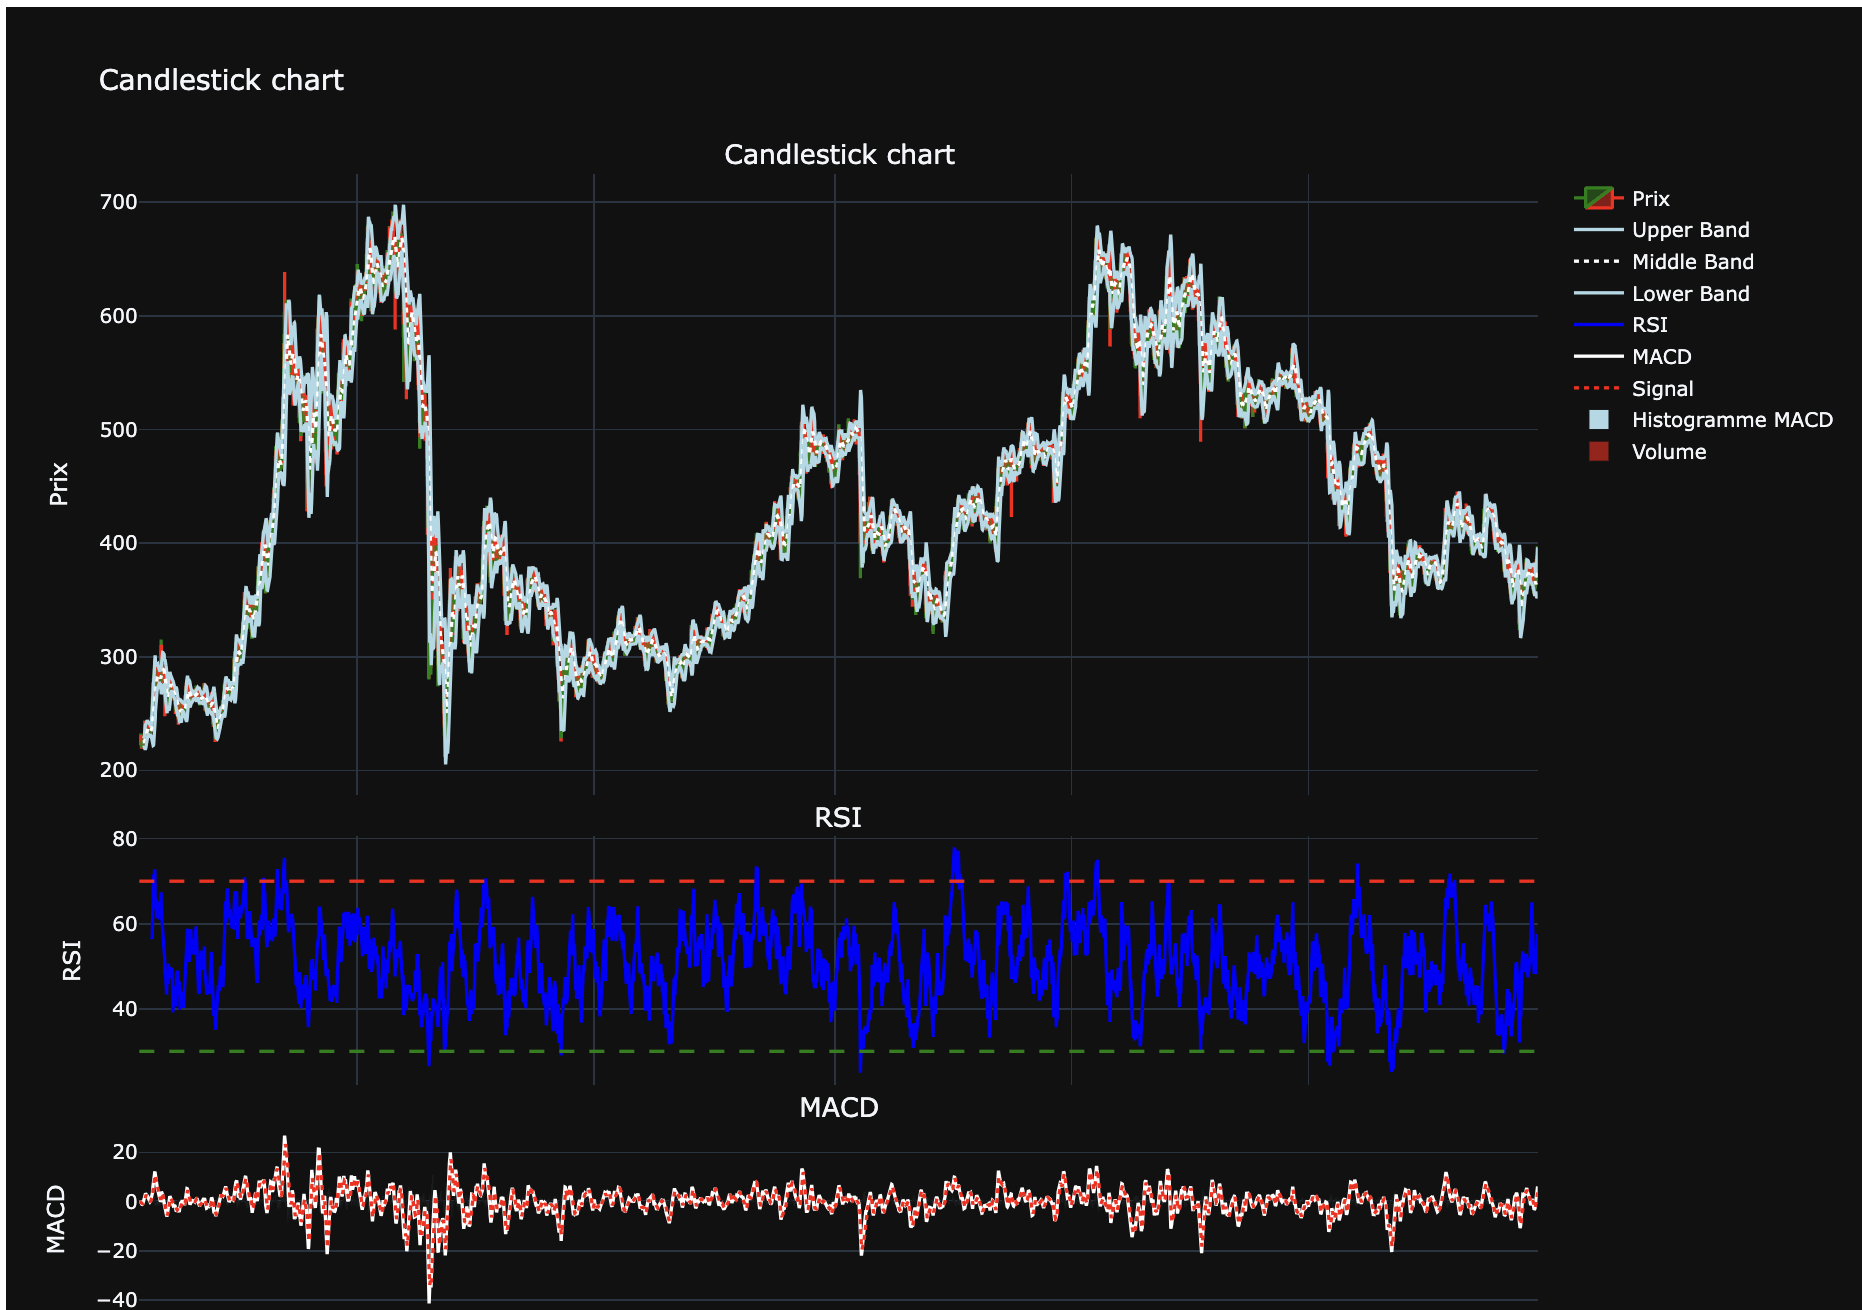

In [64]:
#plot_trend_vfinal_2(df)
display(Image(filename='chart11.png'))

# Part 1 : Entrainement de la strategie

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

- ##### "detect_extremes" : Locates zones where the price leaves the Bollinger bands  and records the extreme points in sliding windows.
- ##### "detect_rsi_divergences" : Identifies bullish (BUY) or bearish (SELL) RSI divergences by comparing the evolution of extreme prices and RSI between two peaks or troughs.
- ##### "detect_entry_points_with_sl_improved_tp_" : Looks for the moment when the RSI crosses 50 after a signal, then calculates an entry point, a stop-loss based on recent Bollinger bands, and a take-profit with a fixed risk/reward ratio.
- ##### "run_backtest_part_1" : Simulates the execution of detected trades, following their progress candle by candle until take profit, stop loss or end of period (EOD), while updating capital and recording each PnL.
- ##### "train_strat" : Prepares historical trade data, encodes features, then trains two machine learning models (Random Forest and XGBoost) to predict whether a trade will win (TAKE PROFIT) or not.

In [41]:
# Attention we have defined min max variables upstream so we reset here

if 'min' in locals() : 
    del min     
elif 'max' in locals() : 
    del max

def detect_extremes(df, window=40, min_spacing=18):
    results = []

    for i in range(len(df) - window + 1):
        sub_df = df.iloc[i:i + window].copy()

        # Lows under the bottom band
        lows_below_band = sub_df[sub_df['low'] < sub_df['Bollinger_Lower']]
        sorted_lows = lows_below_band.sort_values(by='low')
        selected_lows = []
        for idx, row in sorted_lows.iterrows():
            if not selected_lows:
                selected_lows.append((idx, row['low']))
            elif abs(idx - selected_lows[0][0]) >= min_spacing:
                selected_lows.append((idx, row['low']))
                break

        # Highs above the top band
        highs_above_band = sub_df[sub_df['high'] > sub_df['Bollinger_Upper']]
        sorted_highs = highs_above_band.sort_values(by='high', ascending=False)
        selected_highs = []
        for idx, row in sorted_highs.iterrows():
            if not selected_highs:
                selected_highs.append((idx, row['high']))
            elif abs(idx - selected_highs[0][0]) >= min_spacing:
                selected_highs.append((idx, row['high']))
                break

        # Add result only if at least one max or min detected
        if len(selected_lows) >= 2 or len(selected_highs) >= 2:
            results.append({
                'index_start': sub_df.index[0],
                'index_end': sub_df.index[-1],
                'min_lows': selected_lows if len(selected_lows) == 2 else None,
                'max_highs': selected_highs if len(selected_highs) == 2 else None
            })

    return results

def detect_rsi_divergences(df, results):
    signals = []

    for r in results:
        # BEARISH DIVERGENCE: SELL 
        if r['max_highs'] is not None:
            (idx2, high2), (idx1, high1) = r['max_highs']
            if high2 > high1:
                rsi1 = df.loc[idx1, 'RSI_value']
                rsi2 = df.loc[idx2, 'RSI_value']
                if rsi2 < rsi1:
                    signals.append({
                        'type': 'SELL',
                        'window_start': r['index_start'],
                        'window_end': r['index_end'],
                        'index1': idx1,
                        'index2': idx2,
                        'price_points': (high1, high2),
                        'RSI_values': (rsi1, rsi2)
                    })

        # BULLISH DIVERGENCE: BUY
        if r['min_lows'] is not None:
            (idx2, low2), (idx1, low1) = r['min_lows']
            if low2 < low1:
                rsi1 = df.loc[idx1, 'RSI_value']
                rsi2 = df.loc[idx2, 'RSI_value']
                if rsi2 > rsi1:
                    signals.append({
                        'type': 'BUY',
                        'window_start': r['index_start'],
                        'window_end': r['index_end'],
                        'index1': idx1,
                        'index2': idx2,
                        'price_points': (low1, low2),
                        'RSI_values': (rsi1, rsi2)
                    })

    return signals

def detect_entry_points_with_sl_tp_tst(df, signals, sl_lookback=24, rr_ratio=2):
    entries = []
    idx_end = df.index[-1]

    for sig in signals:
        idx_start = sig['index2']

        # Boucle sur les vrais index
        for idx in df.loc[idx_start + 1:idx_end].index:
            rsi_prev = df.loc[idx - 1, 'RSI_value']
            rsi_now = df.loc[idx, 'RSI_value']

            is_buy = sig['type'] == 'BUY'
            is_sell = sig['type'] == 'SELL'

            crossed_50 = (
                (is_buy and rsi_prev < 50 and rsi_now >= 50) or
                (is_sell and rsi_prev > 50 and rsi_now <= 50)
            )

            if crossed_50:
                entry_price = df.loc[idx, 'close']

                if is_buy:
                    sl_zone = df.loc[max(df.index[0], idx - sl_lookback):idx - 1, 'Bollinger_Lower']
                    if sl_zone.empty:
                        continue
                    stop_loss = sl_zone.min()

                    boll_ref = df.loc[idx, 'Bollinger_Lower']
                    tp_distance = abs(entry_price - boll_ref) * rr_ratio
                    take_profit = entry_price + tp_distance

                elif is_sell:
                    sl_zone = df.loc[max(df.index[0], idx - sl_lookback):idx - 1, 'Bollinger_Upper']
                    if sl_zone.empty:
                        continue
                    stop_loss = sl_zone.max()

                    boll_ref = df.loc[idx, 'Bollinger_Upper']
                    tp_distance = abs(entry_price - boll_ref) * rr_ratio
                    take_profit = entry_price - tp_distance

                entries.append({
                    **sig,
                    'entry_index': idx,
                    'entry_price': entry_price,
                    'entry_rsi': rsi_now,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit
                })
                break  # on s'arrête au premier croisement

    return entries

def detect_entry_points_with_sl_improved_tp_(df, signals, sl_lookback=24, rr_ratio=2.5):
    entries = []
    idx_end = df.index[-1]

    for sig in signals:
        idx_start = sig['index2']

        # Loop on real indexes
        for idx in df.loc[idx_start + 1:idx_end].index:
            rsi_prev = df.loc[idx - 1, 'RSI_value']
            rsi_now = df.loc[idx, 'RSI_value']

            is_buy = sig['type'] == 'BUY'
            is_sell = sig['type'] == 'SELL'

            crossed_50 = (
                (is_buy and rsi_prev < 50 and rsi_now >= 50) or
                (is_sell and rsi_prev > 50 and rsi_now <= 50)
            )

            if crossed_50:
                entry_price = df.loc[idx, 'close']

                if is_buy:
                    try:
                        start_pos = max(0, df.index.get_loc(idx) - sl_lookback)
                        end_pos = df.index.get_loc(idx)
                        sl_zone = df.iloc[start_pos:end_pos, df.columns.get_loc('Bollinger_Lower')]
                    except:
                        continue

                    if sl_zone.empty:
                        continue
                    bollinger_mean = sl_zone.mean()
                    sl_price_pct = entry_price * (1 - 0.05)  # -5% pour un BUY
                    stop_loss = min(bollinger_mean, sl_price_pct)

                    #boll_ref = df.loc[idx, 'Bollinger_Lower']
                    tp_distance = abs(entry_price - stop_loss) * rr_ratio
                    take_profit = entry_price + tp_distance

                else:  # so SELL
                    try:
                        start_pos = max(0, df.index.get_loc(idx) - sl_lookback)
                        end_pos = df.index.get_loc(idx)
                        sl_zone = df.iloc[start_pos:end_pos, df.columns.get_loc('Bollinger_Lower')]
                    except:
                        continue

                    if sl_zone.empty:
                        continue
                    bollinger_mean = sl_zone.mean()
                    sl_price_pct = entry_price * (1 + 0.05)  # +5% pour un SELL
                    stop_loss = max(bollinger_mean, sl_price_pct)

                    #boll_ref = df.loc[idx, 'Bollinger_Upper']
                    tp_distance = abs(entry_price - stop_loss) * rr_ratio
                    take_profit = entry_price - tp_distance

                entries.append({
                    **sig,
                    'entry_index': idx,
                    'entry_price': entry_price,
                    'entry_rsi': rsi_now,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit
                })
                break  

    return entries

def run_backtest_part_1(df, verbose=True):
    # Step 1: Signal detection
    results = detect_extremes(df, window=40, min_spacing=18)
    if verbose:
        print(f"➡️ Résultats extrêmes détectés : {len(results)}")
    
    divergence_signals = detect_rsi_divergences(df, results)
    if verbose:
        print(f"➡️ Divergences détectées : {len(divergence_signals)}")
    
    entry_orders = detect_entry_points_with_sl_improved_tp_(df, divergence_signals)
    if verbose:
        print(f"➡️ Entrées confirmées (RSI + SL/TP) : {len(entry_orders)}")

    # Initialisation
    capital = 10_000
    capital_history = [capital]
    executed_trades = []

    for order in entry_orders:
        entry_idx = order["entry_index"]
        # ATTENTION TEST
        if entry_idx not in df.index or df.index.get_loc(entry_idx) >= len(df) - 1:
            continue

        entry_price = order["entry_price"]
        take_profit = order["take_profit"]
        stop_loss = order["stop_loss"]
        trade_type = order["type"]

        # Position size: 1% of current capital
        position_size = capital * 0.01
        qty = position_size / entry_price

        # We run the candles from entry_index + 1
        exit_price = None
        exit_index = None
        reason = "HOLD"

        start_pos = df.index.get_loc(entry_idx)
        for i in df.index[start_pos + 1:]:
            high = df.loc[i, "high"]
            low = df.loc[i, "low"]

            if trade_type == "BUY":
                if high >= take_profit:
                    exit_price = take_profit
                    reason = "TAKE PROFIT"
                elif low <= stop_loss:
                    exit_price = stop_loss
                    reason = "STOP LOSS"
            elif trade_type == "SELL":
                if low <= take_profit:
                    exit_price = take_profit
                    reason = "TAKE PROFIT"
                elif high >= stop_loss:
                    exit_price = stop_loss
                    reason = "STOP LOSS"

            if exit_price is not None:
                exit_index = i
                break

        if exit_price is None:
            exit_index = df.index[-1]
            exit_price = df.loc[exit_index, "close"]
            reason = "EOD"


        # PnL calculated according to trade direction
        if trade_type == "BUY":
            pnl = (exit_price - entry_price) * qty
        else:  # SELL
            pnl = (entry_price - exit_price) * qty

        # Exit fees (1% of committed capital)
        fees = 0.01 * position_size
        net_pnl = pnl - fees

        capital += net_pnl
        capital_history.append(capital)

        price_start_signal = order['price_points'][1]
        price_end_signal = order['price_points'][0]
        RSI_start_signal = order['RSI_values'][1]
        RSI_end_signal = order['RSI_values'][0]

        executed_trades.append({
            "type": trade_type,
            "price_start_signal" : price_start_signal,
            "price_end_signal" : price_end_signal, 
            "RSI_start_signal" : RSI_start_signal,
            "RSI_end_signal" : RSI_end_signal, 
            "entry_index": entry_idx,
            "entry_price": entry_price,
            "exit_index": exit_index,
            "exit_price": exit_price,
            "take_profit": take_profit,
            "stop_loss": stop_loss,
            "qty": qty,
            "gross_pnl": pnl,
            "fees": fees,
            "net_pnl": net_pnl,
            "capital_after_trade": capital,
            "reason": reason
        })

    return pd.DataFrame(executed_trades), capital_history

def train_strat (df_trade_hitory) :
    # == Préambule == 
    df_trade_hitory['reason']=df_trade_hitory['reason'].apply(lambda x : 1 if x=='TAKE PROFIT' else 0)
    df_trade_hitory['SELL'] = (df_trade_hitory['type'] == "SELL").astype(int)
    df_trade_hitory['BUY'] = (df_trade_hitory['type'] == "BUY").astype(int)
    df_trade_hitory['delta_price_signal']=abs(df_trade_hitory['price_start_signal']- df_trade_hitory['price_end_signal'])
    df_trade_hitory['delta_RSI_signal']=abs(df_trade_hitory['RSI_start_signal']- df_trade_hitory['RSI_end_signal'])
    df_trade_hitory=df_trade_hitory.drop('type', axis=1)
    df_trade_hitory=df_trade_hitory[['SELL', 'BUY',  'delta_price_signal', 'delta_RSI_signal', 'take_profit', 'stop_loss', 'reason']]
    target= 'reason'

    # model training based on price history and past trades
    X = df_trade_hitory.drop(target, axis=1)
    y = df_trade_hitory[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=2),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=10)
    }
    # on renvoie l'ensembel des models entrainé
    for name, model in models.items():
            model.fit(X_train, y_train)
    return models

#durant les tests on atteint 0.998 de precision et un recall à 0.91 donc lorsqu'on detecte un bon trade c'est censé être vraiment un bon trade

df_trade_hitory, capital = run_backtest_part_1(df_BNB)
models=train_strat(df_trade_hitory)

➡️ Résultats extrêmes détectés : 20541
➡️ Divergences détectées : 5456
➡️ Entrées confirmées (RSI + SL/TP) : 5444


# Part 2 : execution de la strategie 

- ##### "detect_entry_points_with_sl_improved_tp_ML" : This version filters entries thanks to a pre-trained XGBoost model, which predicts whether the trade has a good chance of reaching its take profit before being validated.
- ##### "run_backtest_part2" :  same as run_backtest_part1

In [42]:
def detect_entry_points_with_sl_improved_tp_ML(df, signals, models, sl_lookback=24, rr_ratio=2.5):
    entries = []
    idx_end = df.index[-1]

    for sig in signals:
        idx_start = sig['index2']

        # Boucle sur les vrais index
        for idx in df.loc[idx_start + 1:idx_end].index:
            rsi_prev = df.loc[idx - 1, 'RSI_value']
            rsi_now = df.loc[idx, 'RSI_value']

            is_buy = sig['type'] == 'BUY'
            is_sell = sig['type'] == 'SELL'

            crossed_50 = (
                (is_buy and rsi_prev < 50 and rsi_now >= 50) or
                (is_sell and rsi_prev > 50 and rsi_now <= 50)
            )

            if crossed_50:
                entry_price = df.loc[idx, 'close']

                if is_buy:
                    try:
                        start_pos = max(0, df.index.get_loc(idx) - sl_lookback)
                        end_pos = df.index.get_loc(idx)
                        sl_zone = df.iloc[start_pos:end_pos, df.columns.get_loc('Bollinger_Lower')]
                    except:
                        continue
                    if sl_zone.empty:
                        continue
                    bollinger_mean = sl_zone.mean()
                    sl_price_pct = entry_price * (1 - 0.05)  # -5% pour un BUY
                    stop_loss = min(bollinger_mean, sl_price_pct)

                    #boll_ref = df.loc[idx, 'Bollinger_Lower']
                    tp_distance = abs(entry_price - stop_loss) * rr_ratio
                    take_profit = entry_price + tp_distance

                else:  # donc SELL
                    try:
                        start_pos = max(0, df.index.get_loc(idx) - sl_lookback)
                        end_pos = df.index.get_loc(idx)
                        sl_zone = df.iloc[start_pos:end_pos, df.columns.get_loc('Bollinger_Lower')]
                    except:
                        continue
                    if sl_zone.empty:
                        continue
                    bollinger_mean = sl_zone.mean()
                    sl_price_pct = entry_price * (1 + 0.05)  # +5% pour un SELL
                    stop_loss = max(bollinger_mean, sl_price_pct)

                    #boll_ref = df.loc[idx, 'Bollinger_Upper']
                    tp_distance = abs(entry_price - stop_loss) * rr_ratio
                    take_profit = entry_price - tp_distance

                #donnée à tester : 
                if sig['type']=='BUY' :
                    sell=0
                    buy=1

                else : 
                    sell=1
                    buy=0
                price_start_signal = sig['price_points'][1]
                price_end_signal = sig['price_points'][0]
                RSI_start_signal = sig['RSI_values'][1]
                RSI_end_signal = sig['RSI_values'][0]
                delta_price_signal=abs(price_start_signal-price_end_signal)
                delta_RSI_signal=abs(RSI_start_signal-RSI_end_signal)
                features=[[sell,buy, delta_price_signal, delta_RSI_signal, take_profit,stop_loss]]
                if models['XGBoost'].predict(features)[0] == 0 :
                    break

                entries.append({
                    **sig,
                    'entry_index': idx,
                    'entry_price': entry_price,
                    'entry_rsi': rsi_now,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit
                })
                break  

    return entries

def run_backtest_part2(df, models, leverage=1, verbose=True):
    # Étape 1 : Détection des signaux
    results = detect_extremes(df, window=40, min_spacing=18)
    if verbose:
        print(f"➡️ Résultats extrêmes détectés : {len(results)}")
    
    divergence_signals = detect_rsi_divergences(df, results)
    if verbose:
        print(f"➡️ Divergences détectées : {len(divergence_signals)}")
    
    entry_orders = detect_entry_points_with_sl_improved_tp_ML(df, divergence_signals, models)
    if verbose:
        print(f"➡️ Entrées confirmées (RSI + SL/TP) : {len(entry_orders)}")

    # Initialisation
    capital = 10_000
    capital_history = [capital]
    executed_trades = []

    for order in entry_orders:
        entry_idx = order["entry_index"]
        if entry_idx not in df.index or df.index.get_loc(entry_idx) >= len(df) - 1:
            continue

        entry_price = order["entry_price"]
        take_profit = order["take_profit"]
        stop_loss = order["stop_loss"]
        trade_type = order["type"]

        # Taille de position : 1% du capital actuel
        position_size = capital * 0.01
        qty = (position_size * leverage) / entry_price

        # On parcourt les bougies à partir de entry_index + 1
        exit_price = None
        exit_index = None
        reason = "HOLD"

        start_pos = df.index.get_loc(entry_idx)
        for i in df.index[start_pos + 1:]:
            high = df.loc[i, "high"]
            low = df.loc[i, "low"]

            if trade_type == "BUY":
                if high >= take_profit:
                    exit_price = take_profit
                    reason = "TAKE PROFIT"
                elif low <= stop_loss:
                    exit_price = stop_loss
                    reason = "STOP LOSS"
            elif trade_type == "SELL":
                if low <= take_profit:
                    exit_price = take_profit
                    reason = "TAKE PROFIT"
                elif high >= stop_loss:
                    exit_price = stop_loss
                    reason = "STOP LOSS"

            if exit_price is not None:
                exit_index = i
                break

        if exit_price is None:
            exit_index = df.index[-1]
            exit_price = df.loc[exit_index, "close"]
            reason = "EOD"

        # PnL calculé en fonction du sens du trade
        if trade_type == "BUY":
            pnl = (exit_price - entry_price) * qty
        else:  # SELL
            pnl = (entry_price - exit_price) * qty

        # Frais à la sortie (1% du capital engagé)
        if reason == "EOD":
            # Supposons 0.05% de frais par jour de détention levier
            holding_cost = 0.0005 * leverage * position_size
        else:
            holding_cost = 0

        fees = 0.01 * position_size
        net_pnl = pnl - fees - holding_cost

        capital += net_pnl
        capital_history.append(capital)

        price_start_signal = order['price_points'][1]
        price_end_signal = order['price_points'][0]
        RSI_start_signal = order['RSI_values'][1]
        RSI_end_signal = order['RSI_values'][0]

        executed_trades.append({
            "type": trade_type,
            "price_start_signal" : price_start_signal,
            "price_end_signal" : price_end_signal, 
            "RSI_start_signal" : RSI_start_signal,
            "RSI_end_signal" : RSI_end_signal, 
            "entry_index": entry_idx,
            "entry_price": entry_price,
            "exit_index": exit_index,
            "exit_price": exit_price,
            "take_profit": take_profit,
            "stop_loss": stop_loss,
            "qty": qty,
            "gross_pnl": pnl,
            "fees": fees,
            "net_pnl": net_pnl,
            "capital_after_trade": capital,
            "reason": reason
        })

    return pd.DataFrame(executed_trades), capital_history

df_trade_hitory_XGBoost, capital_XGBoost = run_backtest_part2(df, models, leverage=2)


➡️ Résultats extrêmes détectés : 5267
➡️ Divergences détectées : 1513
➡️ Entrées confirmées (RSI + SL/TP) : 427


# Part 3 : Back Test 

##### Here we simply take out the various statistics useful for integrating a strategy. 

In [43]:
from itertools import groupby
import matplotlib.pyplot as plt

import io

def generate_backtest_statistics_three_column_report(df, df_test, initial_capital=10_000):
    stats = {}

    # === Statistiques principales ===
    stats['candles_analyzed'] = len(df_test)
    winners = df[df['net_pnl'] > 0]
    losers = df[df['net_pnl'] <= 0]
    stats['total_trades'] = len(df)
    stats['winning_trades'] = len(winners)
    stats['losing_trades'] = len(losers)
    stats['win_rate (%)'] = round(len(winners) / len(df) * 100, 2)
    stats['loss_rate (%)'] = round(len(losers) / len(df) * 100, 2)

    total_pnl = df['net_pnl'].sum()
    stats['total_net_pnl'] = total_pnl
    stats['total_return (%)'] = round((total_pnl / initial_capital) * 100, 2)

    stats['mean_net_pnl'] = df['net_pnl'].mean()
    stats['median_net_pnl'] = df['net_pnl'].median()
    stats['max_net_pnl'] = df['net_pnl'].max()
    stats['min_net_pnl'] = df['net_pnl'].min()
    stats['std_net_pnl'] = df['net_pnl'].std()

    for level in [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]:
        stats[f'VaR {int(level*100)}%'] = df['net_pnl'].quantile(level)

    stats['TP count'] = sum(df['reason'] == 'TAKE PROFIT')
    stats['SL count'] = sum(df['reason'] == 'STOP LOSS')
    stats['EOD count'] = sum(df['reason'] == 'EOD')

    streaks = df['net_pnl'] > 0
    stats['max_win_streak'] = max((len(list(g)) for k, g in groupby(streaks) if k), default=0)
    stats['max_loss_streak'] = max((len(list(g)) for k, g in groupby(streaks) if not k), default=0)

    # === Organisation en 3 colonnes ===
    left_col = [
        ("Sample", f"{stats['candles_analyzed']} candles"),
        ("Initial Capital", f"€{initial_capital:,}"),
        ("Total Trades", stats['total_trades']),
        ("Winning Trades", f"{stats['winning_trades']} ({stats['win_rate (%)']}%)"),
        ("Losing Trades", f"{stats['losing_trades']} ({stats['loss_rate (%)']}%)"),
        ("Mean PnL", f"{stats['mean_net_pnl']:.2f}"),
        ("Median PnL", f"{stats['median_net_pnl']:.2f}"),
        ("Max Win Streak", stats['max_win_streak']),
    ]

    right_col = [
        ("Total Net PnL", f"{stats['total_net_pnl']:.2f}"),
        ("Total Return (%)", f"{stats['total_return (%)']}%"),
        ("Max PnL", f"{stats['max_net_pnl']:.2f}"),
        ("Min PnL", f"{stats['min_net_pnl']:.2f}"),
        ("Std Dev PnL", f"{stats['std_net_pnl']:.2f}"),
        ("TP count", stats['TP count']),
        ("SL count", stats['SL count']),
        ("Max Loss Streak", stats['max_loss_streak']),
    ]

    footer_col = [
        ("EOD count", stats['EOD count']),
        ("VaR 1%", f"{stats['VaR 1%']:.2f}"),
        ("VaR 5%", f"{stats['VaR 5%']:.2f}"),
        ("VaR 10%", f"{stats['VaR 10%']:.2f}"),
        ("VaR 25%", f"{stats['VaR 25%']:.2f}"),
        ("VaR 75%", f"{stats['VaR 75%']:.2f}"),
        ("VaR 90%", f"{stats['VaR 90%']:.2f}"),
        ("VaR 95%", f"{stats['VaR 95%']:.2f}"),
        ("VaR 99%", f"{stats['VaR 99%']:.2f}"),
    ]

    max_rows = max(len(left_col), len(right_col), len(footer_col))
    left_col += [("", "")] * (max_rows - len(left_col))
    right_col += [("", "")] * (max_rows - len(right_col))
    footer_col += [("", "")] * (max_rows - len(footer_col))

    output = io.StringIO()
    output.write("===================================== BACKTEST RESULTS =====================================\n")
    output.write(f"{'Principal Statistics':<28} | {'Performences Statistics':<28} | {'Value at Risk':<28}\n")
    output.write("-" * 92 + "\n")

    for l, r, t in zip(left_col, right_col, footer_col):
        output.write(f"{l[0]:<18}: {str(l[1]):<8} | {r[0]:<18}: {str(r[1]):<8} | {t[0]:<18}: {str(t[1]):<8}\n")

    
    return left_col, right_col, footer_col

def generate_fully_aligned_report(left_col, right_col, footer_col):
    # Normalisation des tailles des colonnes
    max_rows = max(len(left_col), len(right_col), len(footer_col))
    left_col += [("", "")] * (max_rows - len(left_col))
    right_col += [("", "")] * (max_rows - len(right_col))
    footer_col += [("", "")] * (max_rows - len(footer_col))

    output = io.StringIO()
    output.write("=" * 102 + "\n")
    output.write(f"{'Principal Statistics':<30} | {'Performances Statistics':<30} | {'Value at Risk':<30}\n")
    output.write("-" * 102 + "\n")

    for l, r, f in zip(left_col, right_col, footer_col):
        output.write(
            f"{l[0]:<22} : {str(l[1]):<12} | "
            f"{r[0]:<22} : {str(r[1]):<12} | "
            f"{f[0]:<12} : {str(f[1]):<12}\n"
        )

    output.write("=" * 102 + "\n")
    return output.getvalue()

def generate_backtest_statistics_with_plot(df, df_test, initial_capital=10_000):
    stats = {}

    # 🔍 Nombre de bougies analysées
    stats['candles_analyzed'] = len(df_test)

    # ==== STATISTIQUES ====
    winners = df[df['net_pnl'] > 0]
    losers = df[df['net_pnl'] <= 0]
    stats['total_trades'] = len(df)
    stats['winning_trades'] = len(winners)
    stats['losing_trades'] = len(losers)
    stats['win_rate (%)'] = round(len(winners) / len(df) * 100, 2)
    stats['loss_rate (%)'] = round(len(losers) / len(df) * 100, 2)

    total_pnl = df['net_pnl'].sum()
    stats['total_net_pnl'] = total_pnl
    stats['total_return (%)'] = round((total_pnl / initial_capital) * 100, 2)

    stats['mean_net_pnl'] = df['net_pnl'].mean()
    stats['median_net_pnl'] = df['net_pnl'].median()
    stats['max_net_pnl'] = df['net_pnl'].max()
    stats['min_net_pnl'] = df['net_pnl'].min()
    stats['std_net_pnl'] = df['net_pnl'].std()

    for level in [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]:
        stats[f'VaR {int(level*100)}%'] = df['net_pnl'].quantile(level)

    stats['TP count'] = sum(df['reason'] == 'TAKE PROFIT')
    stats['SL count'] = sum(df['reason'] == 'STOP LOSS')
    stats['EOD count'] = sum(df['reason'] == 'EOD')

    streaks = df['net_pnl'] > 0
    max_win_streak = max((len(list(g)) for k, g in groupby(streaks) if k), default=0)
    max_loss_streak = max((len(list(g)) for k, g in groupby(streaks) if not k), default=0)
    stats['max_win_streak'] = max_win_streak
    stats['max_loss_streak'] = max_loss_streak

    return pd.DataFrame([stats])

def print_backtest_report_horizontal(stats_df):
    stats = stats_df.T
    stats.columns = ["Value"]

    sections = {
        "📈 Performance": [
            "total_net_pnl", "mean_net_pnl", "median_net_pnl", "max_net_pnl", "min_net_pnl", "std_net_pnl",
            "win_rate (%)", "loss_rate (%)"
        ],
        "📉 Risk Metrics (VaR)": [
            "VaR 1%", "VaR 5%", "VaR 10%", "VaR 25%", "VaR 75%", "VaR 90%", "VaR 95%", "VaR 99%"
        ],
        "🔁 Trade Outcomes": [
            "total_trades", "winning_trades", "losing_trades", "TP count", "SL count", "EOD count"
        ],
        "⛓️ Streaks": [
            "max_win_streak", "max_loss_streak"
        ]
    }

    for title, keys in sections.items():
        print(f"\n{title}")
        print("-" * len(title))
        row = ""
        for key in keys:
            if key in stats.index:
                val = stats.loc[key, "Value"]
                row += f"{key:<8}: {val:<10} | "
            else:
                row += f"{key:<8}: {'-':<10} | "
        print(row.strip(" | "))

def plot_backtest_summary(df, df_ID, initial_capital=10_000):
    # Tri par date/ordre des trades
    df_sorted = df.sort_values(by='entry_index').copy()

    # === Capital stratégie cumulée
    df_sorted['strategy_capital'] = initial_capital + df_sorted['net_pnl'].cumsum()

    # === Buy & Hold simple (premier achat, dernière vente)
    buy_price = df_sorted.iloc[0]['entry_price']
    sell_price = df_sorted.iloc[-1]['exit_price']
    buy_and_hold_return = (sell_price - buy_price) / buy_price
    buy_and_hold_capital = initial_capital * (1 + buy_and_hold_return)
    buy_and_hold_line = [buy_and_hold_capital] * len(df_sorted)

    # === Création de la figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- GRAPHE 1 : Évolution capital ---
    axes[0].plot(df_sorted['strategy_capital'].values, label="Stratégie ML", color='orange', linewidth=2)
    axes[0].plot(buy_and_hold_line, label="Buy & Hold", color='gray', linestyle='--')

    axes[0].fill_between(
        range(len(df_sorted)),
        df_sorted['strategy_capital'].values,
        buy_and_hold_line,
        where=(df_sorted['strategy_capital'].values >= buy_and_hold_line),
        interpolate=True, color='green', alpha=0.3, label='Surperformance'
    )
    axes[0].fill_between(
        range(len(df_sorted)),
        df_sorted['strategy_capital'].values,
        buy_and_hold_line,
        where=(df_sorted['strategy_capital'].values < buy_and_hold_line),
        interpolate=True, color='red', alpha=0.3, label='Sous-performance'
    )
    
    axes[0].set_title(f"Comparaison Stratégie ML vs Buy & Hold {df_ID['symbol'].unique()[0]}")
    axes[0].set_xlabel("Trade #")
    axes[0].set_ylabel("Capital")
    axes[0].legend()
    axes[0].grid(True)

    # --- GRAPHE 2 : Entrées/Sorties sur les prix ---
    price_series = pd.Series(dtype=float)
    for _, row in df_sorted.iterrows():
        price_series.loc[row['entry_index']] = row['entry_price']
        price_series.loc[row['exit_index']] = row['exit_price']

    price_series = price_series.sort_index().ffill()

    axes[1].plot(price_series.index, price_series.values, label="Prix", color='black')
    axes[1].scatter(df_sorted['entry_index'], df_sorted['entry_price'], color='blue', label='Entrée', marker='^')
    axes[1].scatter(df_sorted['exit_index'], df_sorted['exit_price'], color='red', label='Sortie', marker='v')

    axes[1].set_title("Trades sur le graphique de prix")
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Prix")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_strategy_vs_buy_and_hold(df, df_ID, initial_capital=10_000):
    # Tri du DataFrame par ordre chronologique
    df_sorted = df.sort_values(by='entry_index').copy()

    # Capital de la stratégie (cumul du net_pnl)
    df_sorted['strategy_capital'] = initial_capital + df_sorted['net_pnl'].cumsum()

    # Buy & hold : simple différence entre premier prix d'achat et dernier prix de vente
    buy_price = df_sorted.iloc[0]['entry_price']
    sell_price = df_sorted.iloc[-1]['exit_price']
    buy_and_hold_return = (sell_price - buy_price) / buy_price
    buy_and_hold_capital = initial_capital * (1 + buy_and_hold_return)

    # Ligne horizontale pour Buy & Hold
    buy_and_hold_line = [buy_and_hold_capital] * len(df_sorted)

    # Création du graphe
    plt.figure(figsize=(10, 5))
    plt.plot(df_sorted['strategy_capital'].values, label="Stratégie ML", color='orange', linewidth=2)
    plt.plot(buy_and_hold_line, label="Buy & Hold", color='gray', linestyle='--')

    # Zones colorées
    plt.fill_between(
        range(len(df_sorted)),
        df_sorted['strategy_capital'].values,
        buy_and_hold_line,
        where=(df_sorted['strategy_capital'].values >= buy_and_hold_line),
        interpolate=True,
        color='green',
        alpha=0.3,
        label='Surperformance'
    )
    plt.fill_between(
        range(len(df_sorted)),
        df_sorted['strategy_capital'].values,
        buy_and_hold_line,
        where=(df_sorted['strategy_capital'].values < buy_and_hold_line),
        interpolate=True,
        color='red',
        alpha=0.3,
        label='Sous-performance'
    )

    # Mise en forme
    plt.title(f"Comparaison Stratégie ML vs Buy & Hold {df_ID['symbol'].unique()[0]}")
    plt.xlabel("Trade #")
    plt.ylabel("Capital")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Principal Statistics           | Performances Statistics        | Value at Risk                 
------------------------------------------------------------------------------------------------------
Sample                 : 8628 candles | Total Net PnL          : 9748.73      | EOD count    : 0           
Initial Capital        : €10,000      | Total Return (%)       : 97.49%       | VaR 1%       : -27.66      
Total Trades           : 427          | Max PnL                : 50.74        | VaR 5%       : -26.83      
Winning Trades         : 316 (74.0%)  | Min PnL                : -32.01       | VaR 10%      : -22.43      
Losing Trades          : 111 (26.0%)  | Std Dev PnL            : 27.65        | VaR 25%      : -20.42      
Mean PnL               : 22.83        | TP count               : 316          | VaR 75%      : 41.99       
Median PnL             : 36.23        | SL count               : 111          | VaR 90%      : 46.52       
Max Win Streak         : 283          | Max 

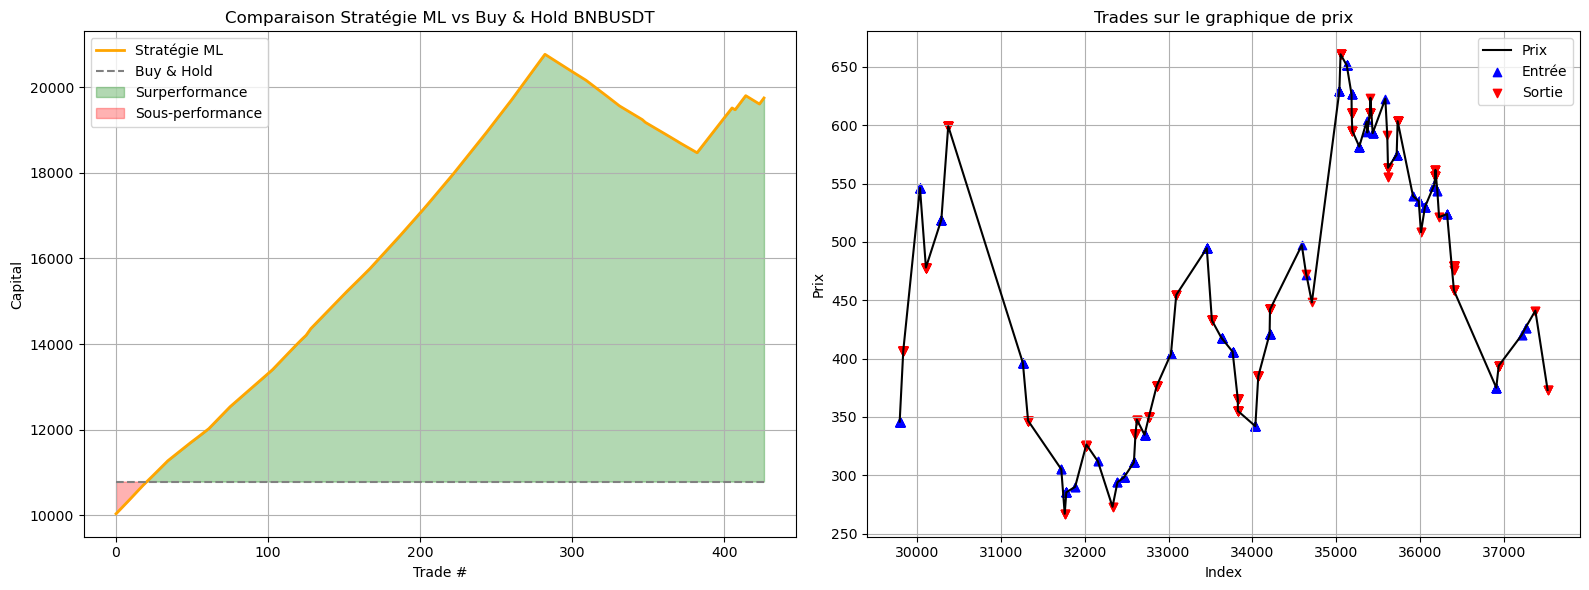

In [44]:
left_col, right_col, footer_col = generate_backtest_statistics_three_column_report(df_trade_hitory_XGBoost, df)
report=generate_fully_aligned_report(left_col, right_col, footer_col)
print(report)
plot_backtest_summary(df_trade_hitory_XGBoost, df_BNB)

# Stability test :

### 1) Flat, low-volatility period : 

#### We run a function block that we've defined and explained beforehand to speed up this part.

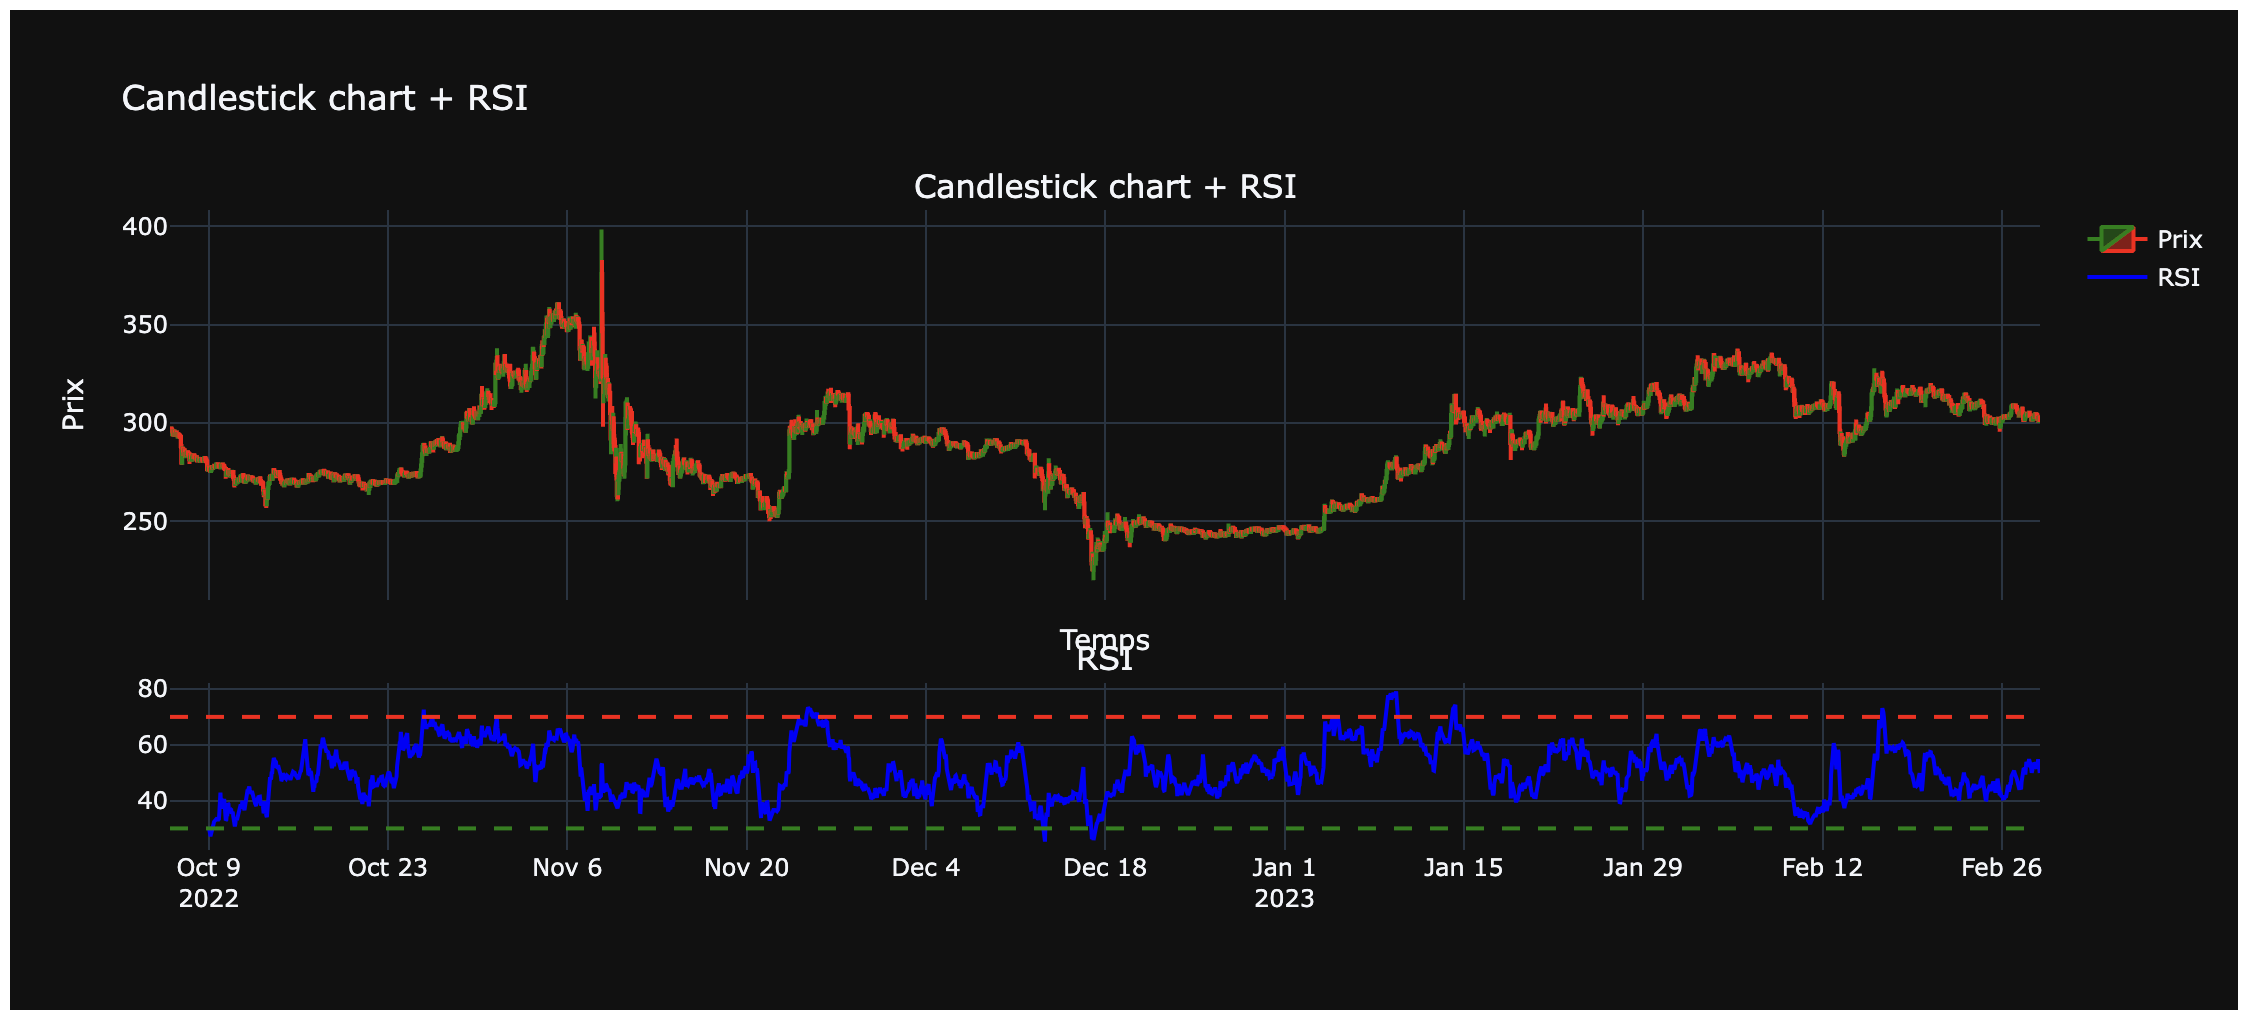

In [65]:
df = BNB_USDT[
    (BNB_USDT['open_time'] >= '2022-10-06') & 
    (BNB_USDT['open_time'] < '2023-03-01')
]

df['mid_price']=(df['low']+df['high'])/2
df['RSI_value'] = compute_rsi(df['mid_price'], window=72)
df['RSI_signal'] = df['RSI_value'].apply(interpret_rsi)
df=compute_macd(df)
df=compute_bollinger_bands(df)

df_BNB_Flat= BNB_USDT[
    (BNB_USDT['open_time'] >= '2018-01-06') & 
    (BNB_USDT['open_time'] < '2022-10-01')
]
df_BNB_Flat['mid_price']=(df_BNB_Flat['low']+df_BNB_Flat['high'])/2
df_BNB_Flat['RSI_value'] = compute_rsi(df_BNB_Flat['mid_price'], window=72)
df_BNB_Flat['RSI_signal'] = df_BNB_Flat['RSI_value'].apply(interpret_rsi)
df_BNB_Flat=compute_macd(df_BNB_Flat)
df_BNB_Flat=compute_bollinger_bands(df_BNB_Flat)

#plot_candlestick_with_rsi(df)
display(Image(filename='chart12.png'))

➡️ Résultats extrêmes détectés : 26200
➡️ Divergences détectées : 7067
➡️ Entrées confirmées (RSI + SL/TP) : 7067
➡️ Résultats extrêmes détectés : 2237
➡️ Divergences détectées : 747
➡️ Entrées confirmées (RSI + SL/TP) : 237
Principal Statistics           | Performances Statistics        | Value at Risk                 
------------------------------------------------------------------------------------------------------
Sample                 : 3504 candles | Total Net PnL          : -454.39      | EOD count    : 17          
Initial Capital        : €10,000      | Total Return (%)       : -4.54%       | VaR 1%       : -11.32      
Total Trades           : 237          | Max PnL                : 24.68        | VaR 5%       : -11.20      
Winning Trades         : 60 (25.32%)  | Min PnL                : -11.84       | VaR 10%      : -11.06      
Losing Trades          : 177 (74.68%) | Std Dev PnL            : 14.58        | VaR 25%      : -10.82      
Mean PnL               : -1.92     

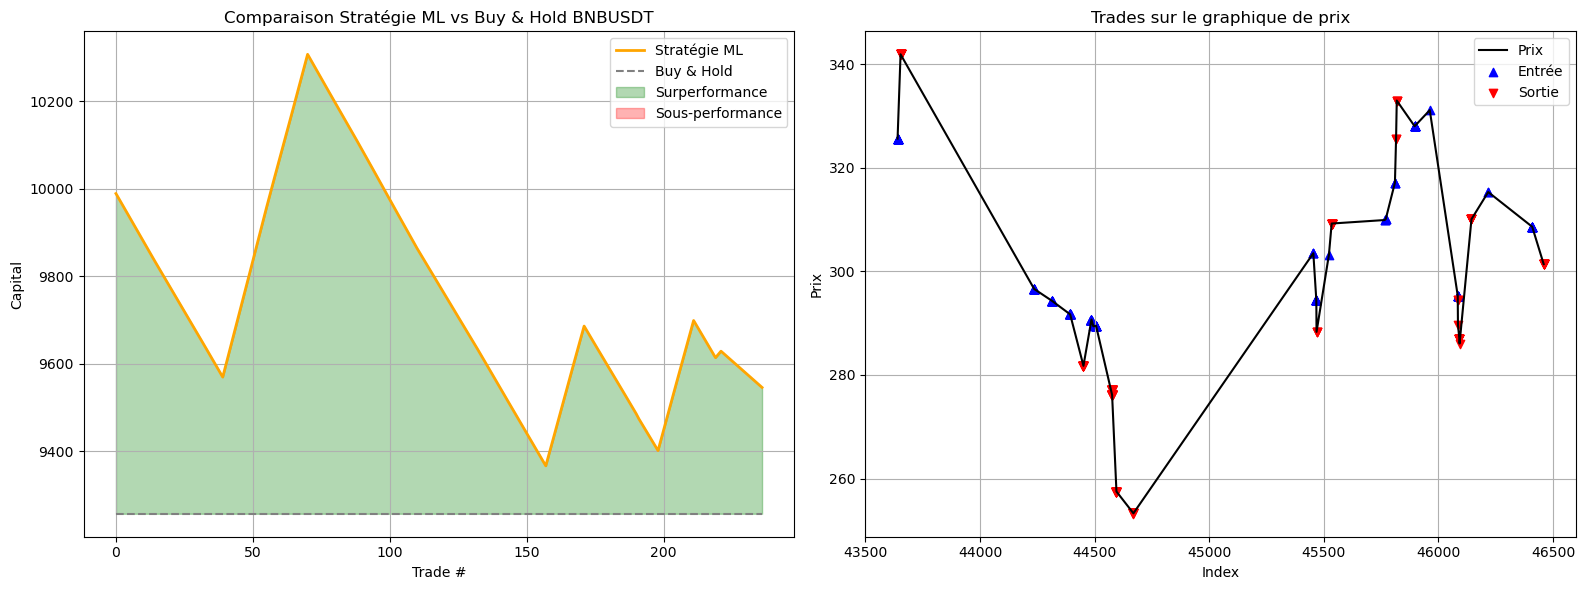

In [46]:
df_trade_hitory, capital = run_backtest_part_1(df_BNB_Flat)
models=train_strat(df_trade_hitory)
df_trade_hitory_XGBoost, capital_XGBoost = run_backtest_part2(df, models, leverage=2)

left_col, right_col, footer_col = generate_backtest_statistics_three_column_report(df_trade_hitory_XGBoost, df)
report=generate_fully_aligned_report(left_col, right_col, footer_col)
print(report)
plot_backtest_summary(df_trade_hitory_XGBoost, df_BNB_Flat)

## Commentary: 

#### Here we can see that the strategy was effective until around November 13, 2022, i.e. before the share price became “soft” again. 
#### So it's important to understand that the strategy is a winner provided the share price remains highly volatile. You can test this empirically by modifying the test periods.

# Test on BTC et ETH

# BTC 

In [66]:
BTC_USDT=pd.read_csv('BTCUSDT_1h_20170817_20250328.csv')
BTC_USDT['open_time']=pd.to_datetime(BTC_USDT['open_time'])
BTC_USDT['close_time']=pd.to_datetime(BTC_USDT['close_time'])
df = BTC_USDT[
    (BTC_USDT['open_time'] >= '2021-01-06') & 
    (BTC_USDT['open_time'] < '2022-01-01')
]
# Je choisi des periodes de grandes fluctuations
df['mid_price']=(df['low']+df['high'])/2
df['RSI_value'] = compute_rsi(df['mid_price'], window=72)
df['RSI_signal'] = df['RSI_value'].apply(interpret_rsi)
df=compute_macd(df)
df=compute_bollinger_bands(df)

df_BTC= BTC_USDT[
    (BTC_USDT['open_time'] >= '2018-01-06') & 
    (BTC_USDT['open_time'] < '2021-10-01')
]
df_BTC['mid_price']=(df_BTC['low']+df_BTC['high'])/2
df_BTC['RSI_value'] = compute_rsi(df_BTC['mid_price'], window=72)
df_BTC['RSI_signal'] = df_BTC['RSI_value'].apply(interpret_rsi)
df_BTC=compute_macd(df_BTC)
df_BTC=compute_bollinger_bands(df_BTC)

plot_candlestick_with_rsi(df)
#display(Image(filename='chart13.png'))

➡️ Résultats extrêmes détectés : 21938
➡️ Divergences détectées : 6762
➡️ Entrées confirmées (RSI + SL/TP) : 6744
➡️ Résultats extrêmes détectés : 5879
➡️ Divergences détectées : 1771
➡️ Entrées confirmées (RSI + SL/TP) : 258
Principal Statistics           | Performances Statistics        | Value at Risk                 
------------------------------------------------------------------------------------------------------
Sample                 : 8627 candles | Total Net PnL          : 7596.01      | EOD count    : 1           
Initial Capital        : €10,000      | Total Return (%)       : 75.96%       | VaR 1%       : -19.72      
Total Trades           : 258          | Max PnL                : 58.22        | VaR 5%       : -19.50      
Winning Trades         : 238 (92.25%) | Min PnL                : -19.77       | VaR 10%      : 24.33       
Losing Trades          : 20 (7.75%)   | Std Dev PnL            : 16.00        | VaR 25%      : 26.69       
Mean PnL               : 29.44    

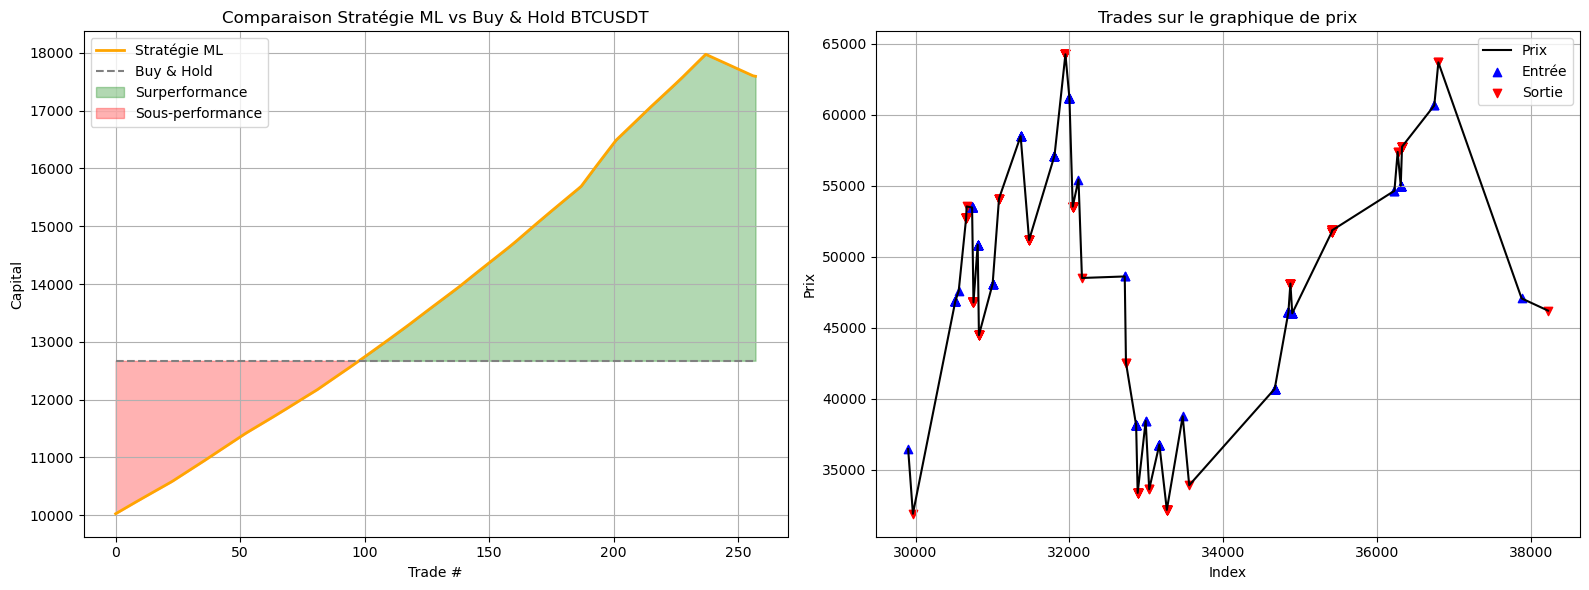

In [48]:
df_trade_hitory, capital = run_backtest_part_1(df_BTC)
models=train_strat(df_trade_hitory)
df_trade_hitory_XGBoost, capital_XGBoost = run_backtest_part2(df, models, leverage=2)

left_col, right_col, footer_col = generate_backtest_statistics_three_column_report(df_trade_hitory_XGBoost, df)
report=generate_fully_aligned_report(left_col, right_col, footer_col)
print(report)
plot_backtest_summary(df_trade_hitory_XGBoost, df_BTC)

# ETH 


In [67]:
ETH_USDT=pd.read_csv('ETHUSDT_1h_20170817_20250328.csv')
ETH_USDT['open_time']=pd.to_datetime(ETH_USDT['open_time'])
ETH_USDT['close_time']=pd.to_datetime(ETH_USDT['close_time'])
df = ETH_USDT[
    (ETH_USDT['open_time'] >= '2021-02-06') & 
    (ETH_USDT['open_time'] < '2022-03-01')
]
# Je choisi des periodes de grandes fluctuations
df['mid_price']=(df['low']+df['high'])/2
df['RSI_value'] = compute_rsi(df['mid_price'], window=72)
df['RSI_signal'] = df['RSI_value'].apply(interpret_rsi)
df=compute_macd(df)
df=compute_bollinger_bands(df)

df_ETH= ETH_USDT[
    (ETH_USDT['open_time'] >= '2018-01-06') & 
    (ETH_USDT['open_time'] < '2021-10-01')
]
df_ETH['mid_price']=(df_ETH['low']+df_ETH['high'])/2
df_ETH['RSI_value'] = compute_rsi(df_ETH['mid_price'], window=72)
df_ETH['RSI_signal'] = df_ETH['RSI_value'].apply(interpret_rsi)
df_ETH=compute_macd(df_ETH)
df_ETH=compute_bollinger_bands(df_ETH)

plot_candlestick_with_rsi(df)
#display(Image(filename='chart14.png'))

➡️ Résultats extrêmes détectés : 20571
➡️ Divergences détectées : 5797
➡️ Entrées confirmées (RSI + SL/TP) : 5797
➡️ Résultats extrêmes détectés : 6420
➡️ Divergences détectées : 1907
➡️ Entrées confirmées (RSI + SL/TP) : 449
Principal Statistics           | Performances Statistics        | Value at Risk                 
------------------------------------------------------------------------------------------------------
Sample                 : 9299 candles | Total Net PnL          : 9937.24      | EOD count    : 0           
Initial Capital        : €10,000      | Total Return (%)       : 99.37%       | VaR 1%       : -33.88      
Total Trades           : 449          | Max PnL                : 107.84       | VaR 5%       : -27.68      
Winning Trades         : 294 (65.48%) | Min PnL                : -34.12       | VaR 10%      : -25.95      
Losing Trades          : 155 (34.52%) | Std Dev PnL            : 37.36        | VaR 25%      : -19.21      
Mean PnL               : 22.13    

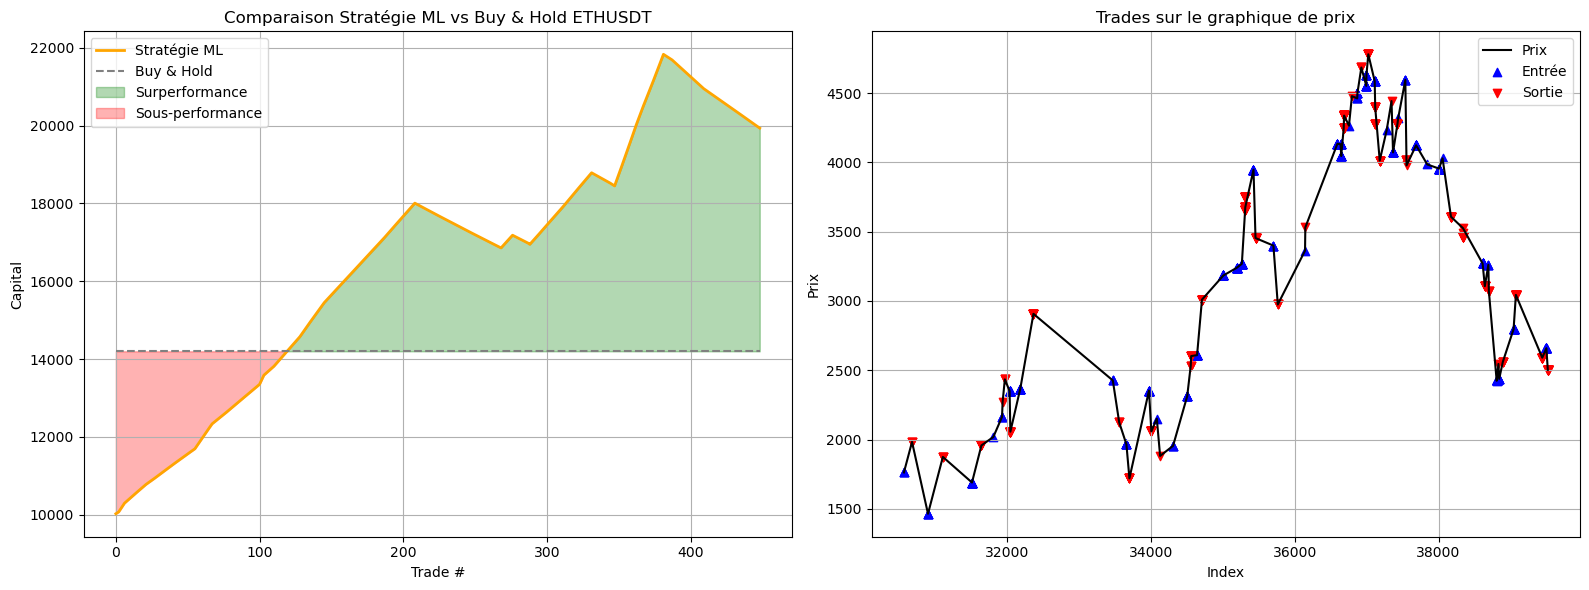

In [50]:
df_trade_hitory, capital = run_backtest_part_1(df_ETH)
models=train_strat(df_trade_hitory)
df_trade_hitory_XGBoost, capital_XGBoost = run_backtest_part2(df, models, leverage=2)

left_col, right_col, footer_col = generate_backtest_statistics_three_column_report(df_trade_hitory_XGBoost, df)
report=generate_fully_aligned_report(left_col, right_col, footer_col)
print(report)
plot_backtest_summary(df_trade_hitory_XGBoost, df_ETH)

# Conclusion :
#### We could now go a step further and integrate the psychological thresholds we've calculated upstream into our stop loss and take profit calculations, as well as integrating global and punctual trends, as our algorithm showed us so well earlier in the project. 

#### This could also be integrated into the back test to exit the position before a take profit or stop loss, should a psychological threshold, resistance or trend support be broken. This implies dynamically searching for continuity or the start of a new trend at each iteration, as well as for psychological thresholds, and so research must be undertaken to determine a large enough and useful observation zone to continuously determine trend AND psychological thresholds. 

#### Of course, all this also means optimizing the whole program so that it can run continuously and quickly. 

# Thank you for reading 